<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/content/dam/news/images/noticies/2016/202-nova-marca-uoc.jpg" align="left" width="45%">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.891 · Aprendizaje automático · PEC3</p>
<p style="margin: 0; text-align:right;">2024-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# PEC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos como los diferentes modelos clasifican las observaciones y con cuales obtenemos mayor rendimiento. Después aplicaremos todo lo que hemos aprendido hasta ahora a un dataset nuevo simulando un caso práctico real.

1. [Exploración de algoritmos supervisados](#eje1) \
    1.1. [Carga de datos](#eje10) \
    1.2. [Naive-Bayes](#eje11) \
    1.3. [Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrtático (QDA)](#eje12) \
    1.4. [K vecinos más próximos (KNN)](#eje13) \
    1.5. [Máquinas de soporte vectorial (SVM)](#eje14) \
    1.6. [Árboles de decisión](#eje15) 
2. [Implementación del caso práctico](#eje2)\
    2.1. [Carga de datos](#eje20) \
    2.2. [Análisis Exploratorio de Datos](#eje21) \
    2.3. [Preprocesamiento de Datos](#eje22) \
    2.4. [Modelización](#eje23) 


<u>Consideraciones generales</u>:

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
    <strong>Nombre y apellidos: Marina Fernández Delgado</strong>
</div>

In [330]:
import os
import shap
import copy
import tqdm
import torch
import pickle
import kagglehub
import umap

import seaborn as sns
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

from matplotlib.colors import ListedColormap

from sklearn import tree
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, train_test_split
from torcheval.metrics.functional import binary_f1_score, binary_accuracy, binary_auroc

%matplotlib inline

In [759]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from sklearn.metrics import roc_curve, auc

# Bibliografía: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.pairwise.haversine_distances.html

<a id='ej1'></a>
# 1. Exploración de algoritmos supervisados

## 1.1. Carga de datos

El conjunto de datos Fashion MNIST proporcionado por Zalando consta de 70.000 imágenes con 10 clases diferentes de ropa repartidas uniformemente. No obstante, para esta práctica utilizaremos únicamente un subconjunto de 5.000 imágenes que consiste en 1.000 imágenes de 5 clases diferentes.

Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones.

El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [332]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
X = data["images"]
y = data["labels"]
n_classes = 5
labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat"]

print("Vector Image Dimensions: {}".format(X.shape))
print("Vector Label Dimensions: {}".format(y.shape))

Vector Image Dimensions: (5000, 784)
Vector Label Dimensions: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

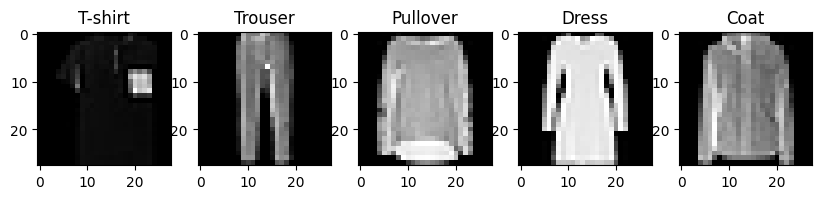

In [333]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(y == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(X[k].reshape(28, 28), cmap="gray")
    ax[i].set_title("{}".format(labels[i]))

plt.show()

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> 

Dividid el _dataset_ en dos subconjuntos, __*train*__ (80% de los datos) y __*test*__ (20% de los datos). Nombrad los conjuntos como: X_train, X_test, y_train, y_test. Utilizad la opción `random_state = 24`.
    
Podéis utilizar la implementación `train_test_split` de `sklearn`.
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

Para poder visualizar los resultados de cada algoritmo supervisado, reduciremos el dataset anterior a dos dimensiones.

c:\Users\USER\Desktop\OUC\Mi unidad\Aprendizaje Automático\Aprendizaje-Automatico\PEC3\.venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


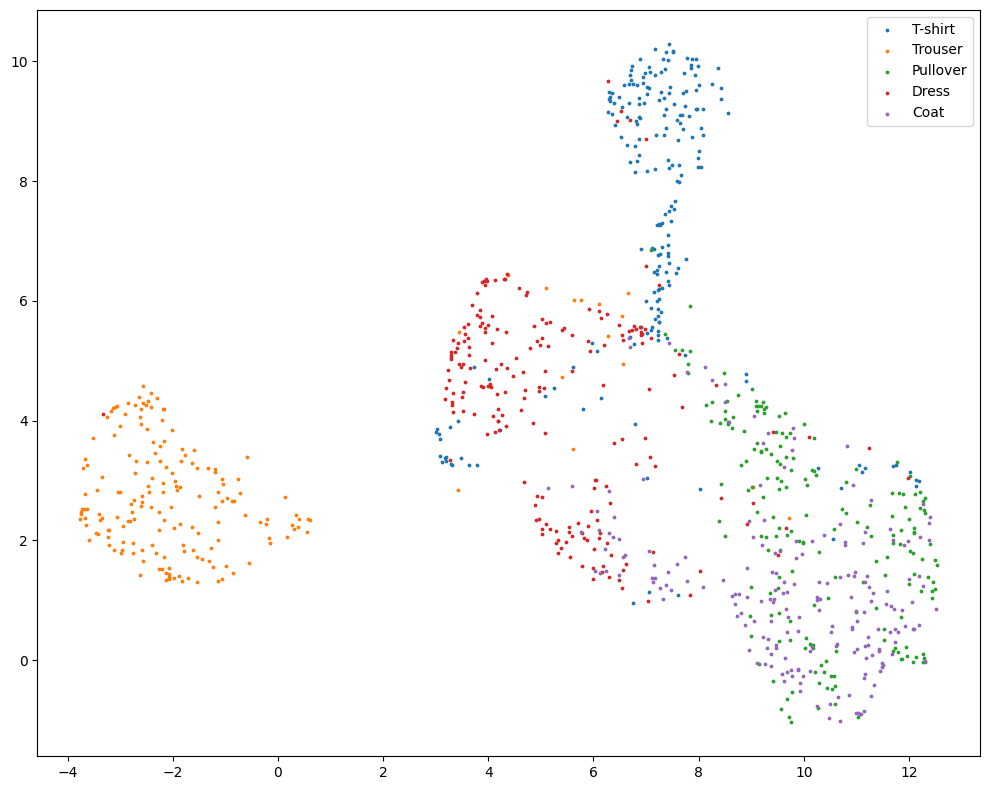

In [335]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(n_classes):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=3, label=labels[i])
plt.legend()
plt.tight_layout()
plt.show()

A lo largo de los ejercicios aprenderemos a ver gráficamente las fronteras de decisión que nos devuelven los diferentes modelos. Para ello utilizaremos la función definida a continuación, que sigue los siguientes pasos:

Crear una meshgrid con los valores mínimo y máximo de 'x' e 'y'.
Predecir el clasificador con los valores de la meshgrid.
Hacer un reshape de los datos para tener el formato correspondiente.
Una vez hecho esto, ya podemos hacer el gráfico de las fronteras de decisión y añadir los puntos reales. Así veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. Al poner encima los puntos veremos si los clasifica correctamente en el área que les corresponde.

In [336]:
# Create the meshgrid with the minimum and maximum values of the x and y axes
x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1

# Define the function that will visualize the decision boundary
def plot_decision_boundaries(model, X_test_projection, y_test):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # Prediction by using all values of the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Define the colors (one for each class)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink'])
    cmap_bold = ['grey','g','sandybrown','c','palevioletred']
    
    # Draw the borders
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Draw the points
    for i in range(n_classes):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], 
                    s=3, label=labels[i], c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

<a id='ej11'></a>
## 1.2. Gaussian Naïve Bayes (1 punto)

El propósito de este primer ejercicio es comprender el funcionamiento del algoritmo Naïve-Bayes, un algoritmo peculiar que se basa en el teorema de Bayes para calcular la probabilidad de que una observación pertenezca a cada una de las clases. Este modelo asume que las características de entrada son independientes entre sí, lo que permite simplificar el cálculo de las probabilidades condicionales.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

1. **Entrena un Modelo de Naïve-Bayes:** Utiliza el conjunto de datos de _train_ para entrenar un modelo de Naïve-Bayes. Emplea el clasificador `GaussianNB` de la biblioteca `sklearn` para este fin.

2. **Calcula el _Accuracy_ del Modelo:** Una vez entrenado el modelo, calcula su precisión (_accuracy_) tanto en el conjunto de _train_ como en el de _test_. Esto te permitirá evaluar qué tan bien está funcionando tu modelo.

3. **Calcula la Matriz de Confusión:** Utiliza el conjunto de _test_ para calcular la matriz de confusión del modelo. Esta matriz te ayudará a entender de mejor manera los aciertos y errores de tu clasificador.

4. **Representa Gráficamente la Frontera de Decisión:** Finalmente, visualiza la frontera de decisión del modelo utilizando el conjunto de _test_. Puedes hacer esto con la ayuda de la función `plot_decision_boundary` que ya has creado previamente.

Para realizar estos cálculos y visualizaciones, utiliza las funciones `accuracy_score` y `confusion_matrix` del paquete `metrics` de `sklearn`.

</div>


<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [337]:
gaussian=GaussianNB().fit(X_train_projection, y_train)

In [338]:
y_train_pred_gauss=gaussian.predict(X_train_projection) 
accuracy_score(y_train, y_train_pred_gauss)

0.75475

In [339]:
y_pred_gauss=gaussian.predict(X_test_projection) 
accuracy_score(y_test, y_pred_gauss)

0.728

In [340]:
confusion_matrix(y_test, y_pred_gauss)

array([[167,   0,  13,  28,   4],
       [  3, 171,   2,  10,   0],
       [ 11,   0, 154,   0,  29],
       [ 23,   1,   6, 157,  18],
       [  7,   0, 107,  10,  79]])

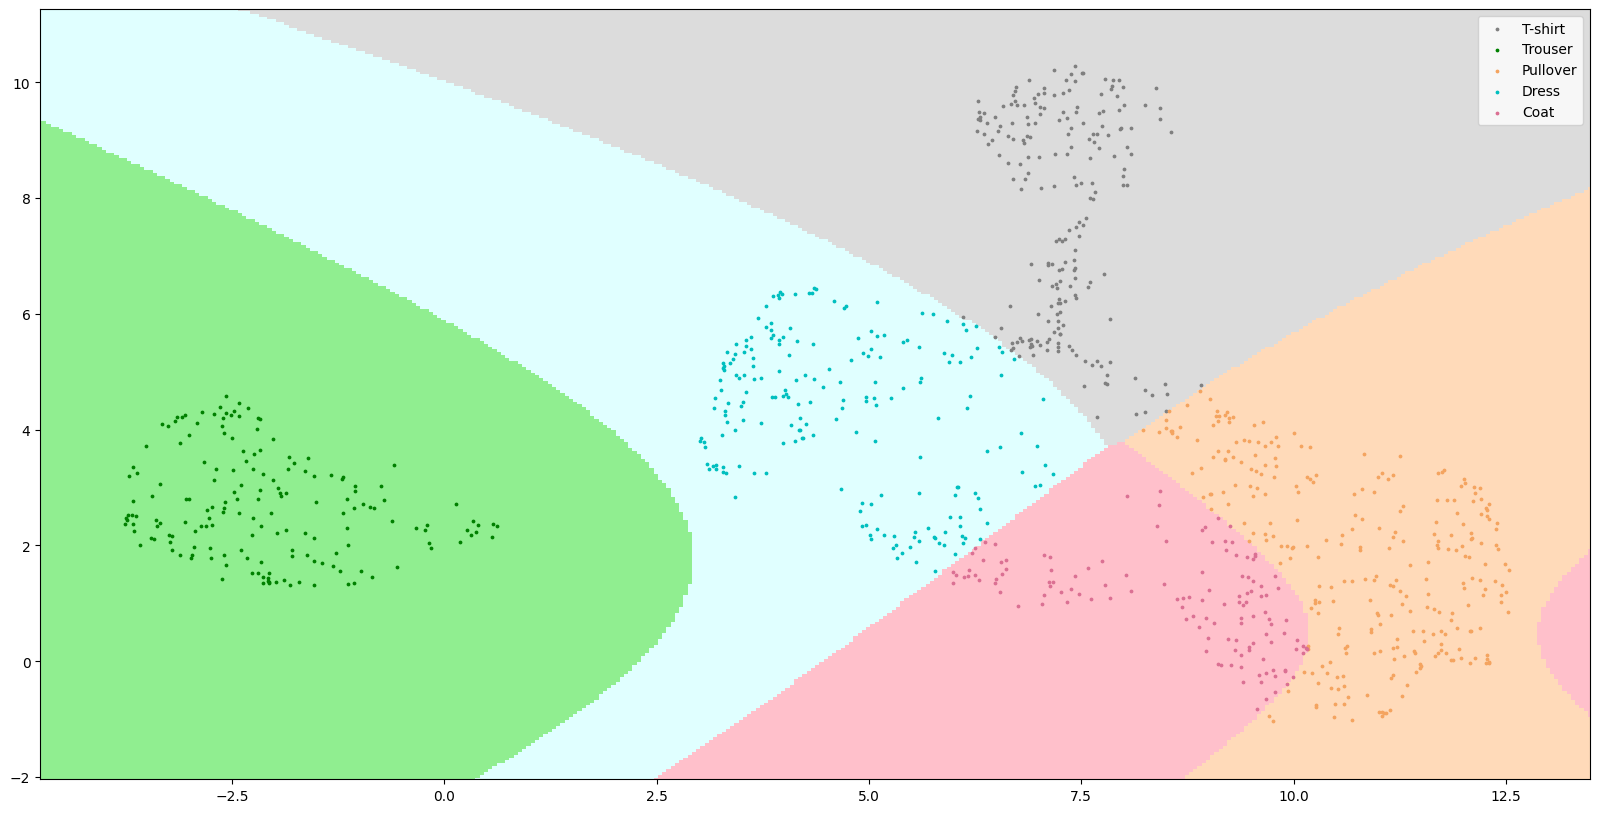

In [341]:
plot_decision_boundaries(gaussian, X_test_projection, y_pred_gauss)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> 
  
Análisis del ejercicio.

   - ¿Cómo son las fronteras de decisión? ¿Tiene sentido que tengan esta forma con el algoritmo utilizado?
   - ¿Cómo son las predicciones obtenidas sobre el conjunto de test?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

El clasificador Gaussian Naive Bayes (GaussianNB) asume que los datos de cada clase siguen una distribución normal/gaussiana, por lo que genera fronteras de decisión basadas en probabilidades. De ahí que la figura muestre curvas suaves, sin que haya líneas/fronteras lineales, siguiendo la distribución de los datos utilizados. 

El ajuste del modelo es de 0.728, donde las clases con mayor separación, como Trouser (naranja en la figura original, verde en la región), tienen regiones más definidas y probablemente contribuyen a una mayor precisión en esa clase. Sin embargo, las clases que están más mezcladas, como T-shirt, Dress y Coat, tienen fronteras más complicadas puesto que los datos están más mezclados, lo que podría explicar la reducción de precisión.
</div>

<a id='ej12'></a>
## 1.3 Análisis Discriminante Lineal (LDA) y Análisis Discriminante Cuadrático (QDA) (1 punto)

Ahora, analizarás dos algoritmos que se basan en la transformación lineal de las características de entrada para maximizar la separación entre las clases. Estos modelos operan bajo la suposición de que las características siguen una distribución gaussiana. Esto te permitirá calcular las probabilidades condicionales de cada clase. Con estos cálculos, asignarás a cada observación la clase que presente la mayor probabilidad condicional.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Sigue estos pasos con el dataset de entrenamiento (_train_):    
    
1. Entrena un modelo de Análisis Discriminante Lineal (LDA) utilizando el clasificador `LinearDiscriminantAnalysis` de `sklearn`.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.

Estas acciones te ayudarán a evaluar la eficacia del modelo LDA en tu conjunto de datos y a entender mejor cómo clasifica las observaciones.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [342]:
LinearDiscriminant = LinearDiscriminantAnalysis().fit(X_train_projection, y_train)

In [343]:
y_train_pred_linear=LinearDiscriminant.predict(X_train_projection) 
accuracy_score(y_train, y_train_pred_linear)

0.75525

In [344]:
y_pred_linear=LinearDiscriminant.predict(X_test_projection) 
accuracy_score(y_test, y_pred_linear)

0.738

In [345]:
confusion_matrix(y_test, y_pred_linear)

array([[164,   0,  14,  30,   4],
       [  3, 171,   2,  10,   0],
       [  9,   0, 135,   0,  50],
       [ 19,   1,   6, 166,  13],
       [  4,   0,  80,  17, 102]])

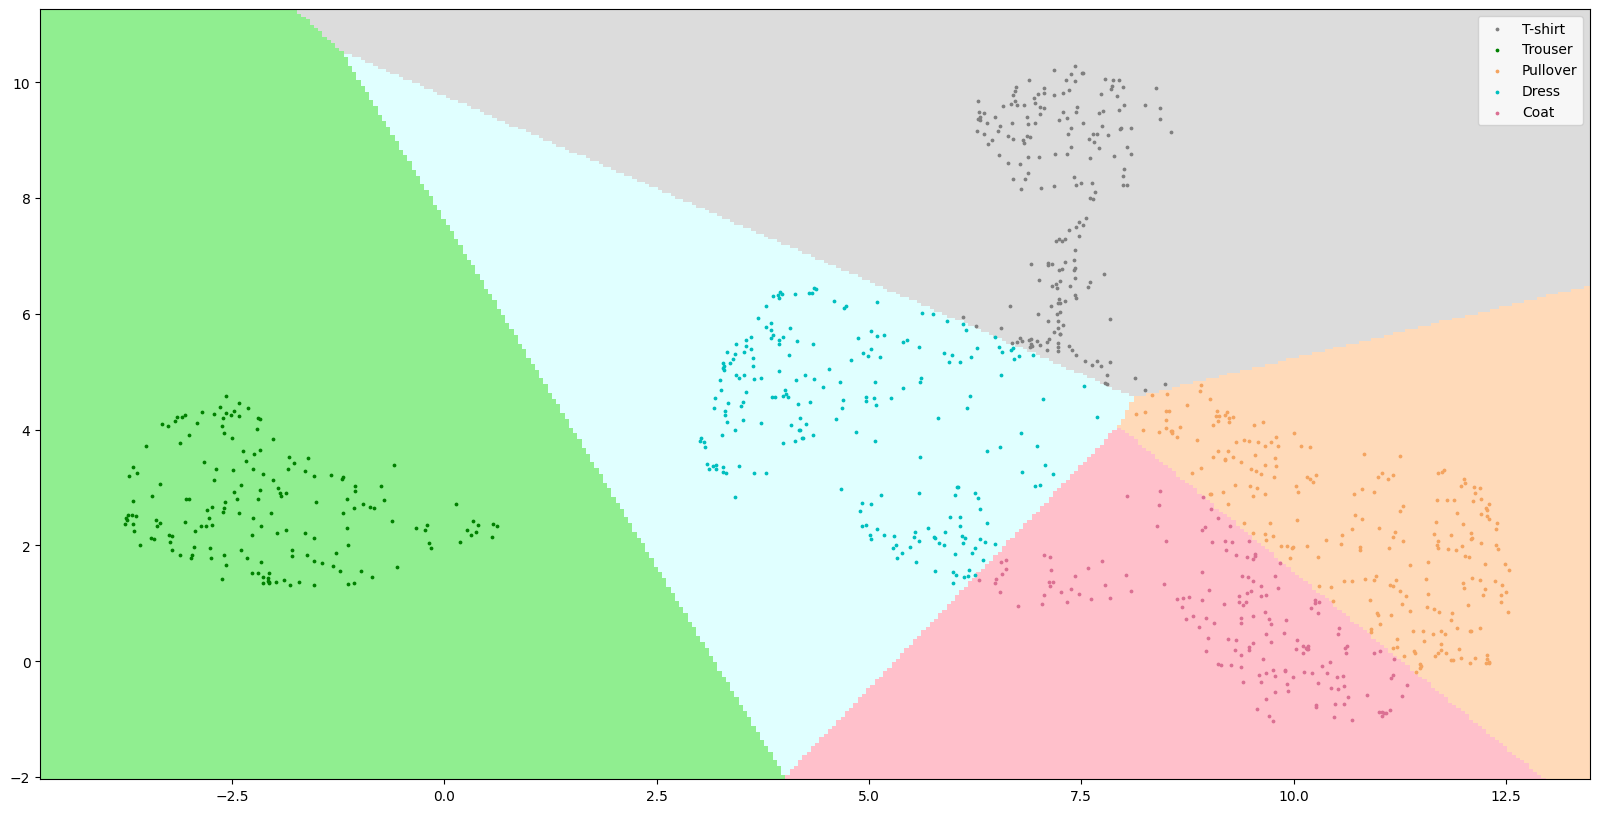

In [346]:
plot_decision_boundaries(LinearDiscriminant, X_test_projection, y_pred_linear)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Observa las fronteras de decisión que has generado. Reflexiona sobre su forma: ¿Se ajustan a lo que esperarías del algoritmo de Análisis Discriminante Lineal (LDA)? Considera la naturaleza lineal del algoritmo y cómo esto influye en la forma de las fronteras.
2. Evalúa las predicciones realizadas sobre el conjunto de test. Analiza su precisión y cómo se distribuyen respecto a las fronteras de decisión. ¿Son coherentes estas predicciones con lo que observas en las fronteras de decisión?

Estas reflexiones te permitirán comprender mejor la efectividad del modelo LDA y su adecuación para el conjunto de datos con el que estás trabajando."
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

Al utilizar el modelo LDA, lo que se espera es obtener fronteras lineales, tal y como se ven en la figura obtendida para este modelo, puesto que éste asume que las clases tienen una distribución gaussiana que comaprten la misma matriz de covarianzas. Al ser lineal, el modelo LDA traza líneas de separación entre las clases en función de la proyección que maximiza la separación entre las medias de las clases y minimiza la dispersión dentro de cada clase. Esto explica por qué las regiones son polígonos definidos por líneas rectas.

La precisión de este modelo es algo superior que al gaussiano (0.738 vs 0.728), por lo que podemos deducir que captura algo mejor los datos, pero tampoco mucho mejor que el modelo anterior. Al observar la distribución de los puntos de prueba, se nota que la mayoría de los puntos caen dentro de las regiones correctas, lo cual concuerda con la precisón obtenida y con la matriz de confusión. Al igual que en el caso anterior, los datos de Trouser tienen una separación muy clara respecto a los demás, lo que hace que se separen mejor. Las clases más cercanas entre sí (T-shirt, Dress y Coat) se clasifican peor puesto que hay puntos superpuestos. 


</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Realiza los siguientes pasos con el dataset de entrenamiento (_train_):

1. Entrena un modelo de Análisis Discriminante Cuadrático (QDA) usando el clasificador `QuadraticDiscriminantAnalysis` de `sklearn`.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.

Estos pasos te ayudarán a evaluar cómo el modelo QDA se comporta con tu conjunto de datos, y a entender su capacidad para clasificar y diferenciar entre las clases."

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [347]:
QuadraticDiscriminant=QuadraticDiscriminantAnalysis().fit(X_train_projection, y_train)

In [348]:
y_train_pred_qua=QuadraticDiscriminant.predict(X_train_projection) 
accuracy_score(y_train, y_train_pred_qua)

0.74225

In [349]:
y_pred_quadratic=QuadraticDiscriminant.predict(X_test_projection) 
accuracy_score(y_test, y_pred_quadratic)

0.724

In [350]:
confusion_matrix(y_test, y_pred_quadratic)

array([[166,   0,  14,  28,   4],
       [  3, 171,   2,  10,   0],
       [  8,   0, 140,   0,  46],
       [ 28,   1,   7, 157,  12],
       [  6,   0,  94,  13,  90]])

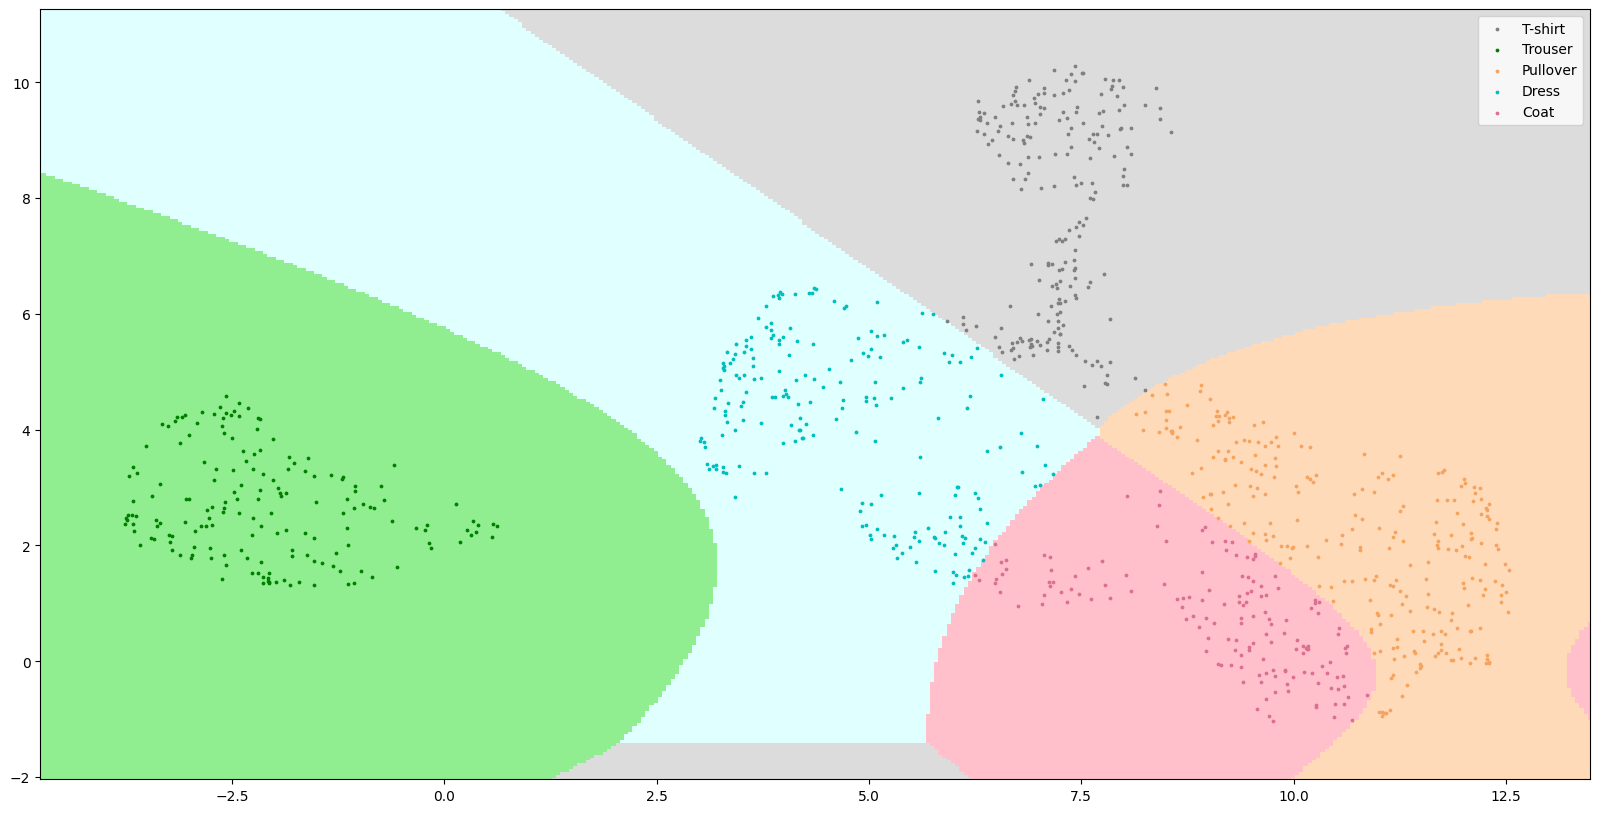

In [351]:
plot_decision_boundaries(QuadraticDiscriminant, X_test_projection, y_pred_quadratic)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Examina las fronteras de decisión que has generado. Reflexiona sobre su forma: ¿Es coherente con lo que esperarías del algoritmo de Análisis Discriminante Cuadrático (QDA)? Considera cómo la naturaleza cuadrática del algoritmo podría influir en la forma de estas fronteras.
2. Evalúa las predicciones realizadas sobre el conjunto de test. Observa su precisión y cómo se distribuyen en relación con las fronteras de decisión. ¿Son estas predicciones consistentes con las fronteras observadas?
3. Reflexiona sobre las diferencias entre los algoritmos LDA y QDA. ¿En qué se distinguen en términos de supuestos, enfoque y resultados en tus datos?

Este análisis te permitirá comprender las características y la eficacia de ambos modelos, LDA y QDA, y cómo se aplican a tu conjunto de datos."
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

El modelo QDA se caracteriza por generar fronteras de forma cuadrática, generando curvas y elipses en las fronteras entre clases, lo que concuerda con la figura obtenida en este apartado. Esto se debe a que el modelo QDA se caracteriza por ser un modelo más flexible que el LDA debido que supone que cada clase tiene su porpia matriz de covarianza, permitiendo mejores suepraciones en distribuciones complejas. 

Sin embargo, si comparamos los modelos LDA y QDA, vemos que la precisión de este segundo (0.724) es ligeramente inferior al primero (0.738). Esto puede deberse a varias razones como es un sobreajuste del prorpio modelo o que debido a intentar separar ha introducido ruido innecesario al modelo. De igual manera que los casos anteriores, Truser es la que mejor se separa y clasifica por no están con los datos superpuestos a los demás. Por otro lado, se puede ver que el modelo QDA no está capturando adecuadamente los datos debido a una peor clasificación de los datos de Pullover y Coat, puesto queal tener regiones solapadas, QDA podría estar tratando de crear fronteras demasiado complejas para capturar las pequeñas diferencias existentes, lo que podría haber introducido errores adicionales.

Los modemos LDA y QDA son algoritmos de clasificación basados en supuestos de distribuciones gaussianas, pero la princpial diferencia que hay entre ellos es en la manera en que modelan la varianza entre clases. LDA asume que todas las clases comparten la misma matriz de covarianza, lo que da lugar a fronteras de decisión lineales, mientras que QDA permite que cada clase tenga su propia matriz de covarianza, generando fronteras cuadráticas más flexibles. Esta flexibilidad adicional hace que QDA pueda capturar relaciones más complejas, pero también lo hace más propenso al sobreajuste. Con los resultados obtenidos, LDA obtuvo uns mejor precisión en el ajuste (73.8%) que QDA (72.4%). Esto sugiere que la separación lineal es suficiente para capturar las diferencias entre las clases de este conjunto de datos. La ligera disminución de precisión del modelo QDA podría ser debido a que las fronteras cuadráticas introducen una complejidad innecesaria.



</div>

<a id='ej13'></a>
## 1.4. KNN (1 punto)

En este punto, vas a entender el funcionamiento del algoritmo KNN (K-Nearest-Neighbor), que se basa en la proximidad de los puntos de datos en un espacio de características. Analizarás sus ventajas y desventajas, y comprenderás cómo los parámetros que lo componen influyen en su comportamiento.

KNN es un algoritmo de tipo supervisado basado en instancia. Esto significa:

- Supervisado: Tu conjunto de datos de entrenamiento está etiquetado con la clase o resultado esperado.
- Basado en instancia (_Lazy Learning_): El algoritmo no aprende explícitamente un modelo, como en la Regresión Logística o los árboles de decisión. En cambio, memoriza las instancias de entrenamiento y las utiliza como "conocimiento" en la fase de predicción.

Para entender cómo funciona KNN, sigue estos pasos:

1. Calcula la distancia entre el ítem a clasificar y los demás ítems del dataset de entrenamiento.
2. Selecciona los "k" elementos más cercanos, es decir, aquellos con la menor distancia, según el tipo de distancia que utilices (euclídea, coseno, manhattan, etc).
3. Realiza una "votación de mayoría" entre los k puntos seleccionados: la clase que predomine en estos puntos decidirá la clasificación final del ítem analizado.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Realiza los siguientes pasos con el dataset de entrenamiento (_train_):

1. Entrena un clasificador KNN con el hiperparámetro `n_neighbors=2` usando el clasificador `KNeighborsClassifier` de `sklearn`.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.

Si al entrenar el clasificador aparece un aviso (warning) y deseas ignorarlo, ejecuta el siguiente código antes del entrenamiento:

`import warnings`
`warnings.filterwarnings('ignore', message='^.*will change.*$', category=FutureWarning)`"

Esto te permitirá evaluar la efectividad del modelo KNN con `n_neighbors=2` en tu conjunto de datos, y entender cómo se comporta en términos de clasificación y separación de clases.    
    
    
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [352]:
knn=KNeighborsClassifier(n_neighbors=2).fit(X_train_projection, y_train)

In [353]:
y_train_pred_knn=knn.predict(X_train_projection) 
accuracy_score(y_train, y_train_pred_knn)

0.87825

In [354]:
y_pred_knn=knn.predict(X_test_projection) 
accuracy_score(y_test, y_pred_knn)

0.732

In [355]:
confusion_matrix(y_test, y_pred_knn)

array([[187,   1,   9,  11,   4],
       [  3, 173,   1,   9,   0],
       [  8,   6, 144,   3,  33],
       [ 25,   9,  20, 142,   9],
       [  8,   3,  97,   9,  86]])

c:\Users\USER\Desktop\OUC\Mi unidad\Aprendizaje Automático\Aprendizaje-Automatico\PEC3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


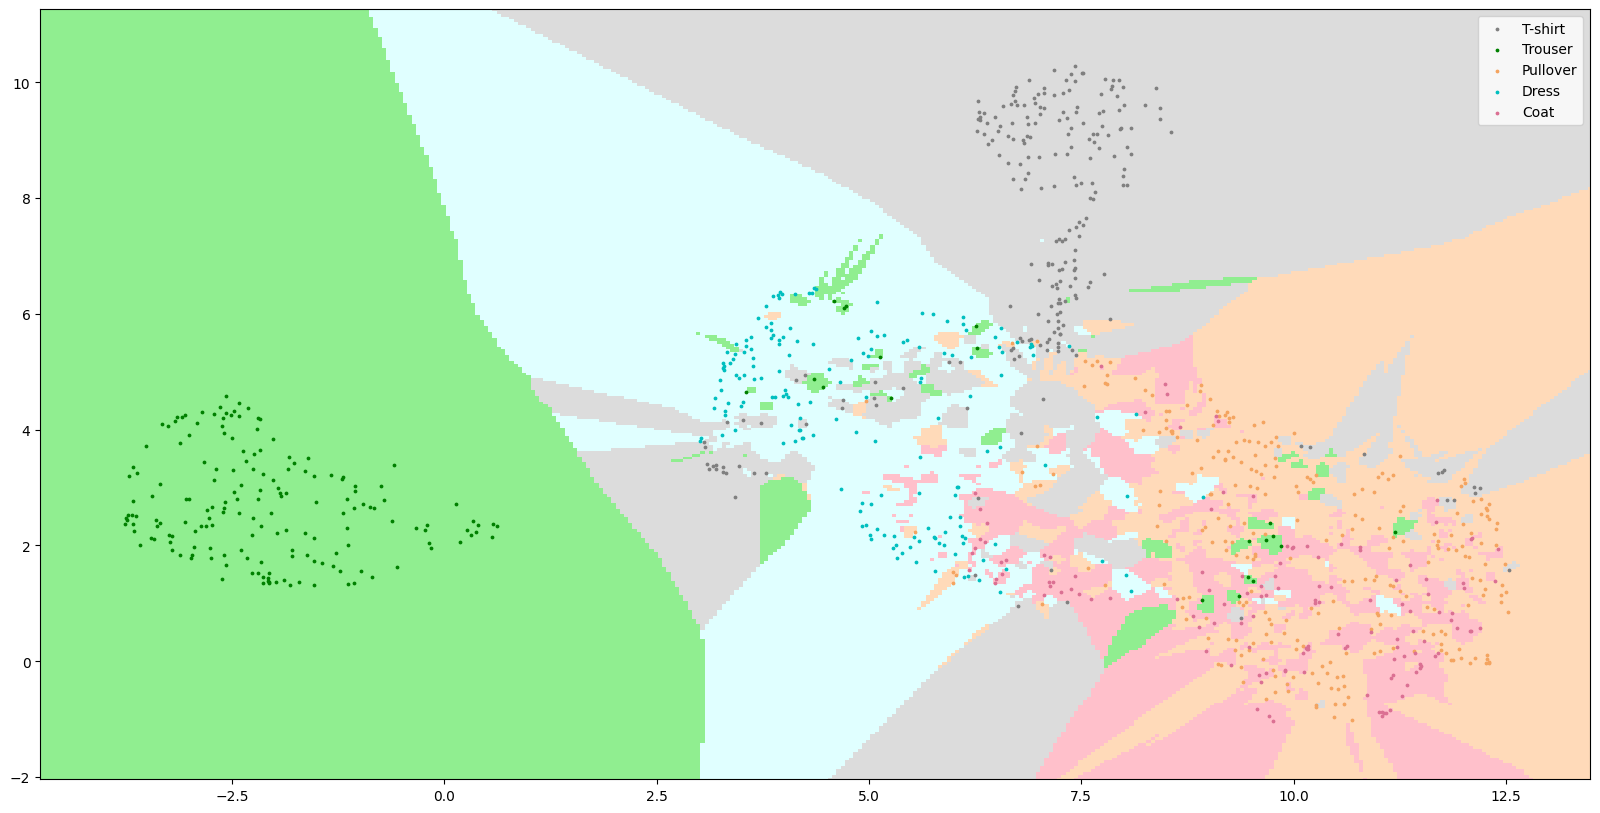

In [356]:
plot_decision_boundaries(knn, X_test_projection, y_pred_knn)

En el modelo que has entrenado, has fijado el parámetro `n_neighbors` de forma arbitraria. Sin embargo, es posible que con otro valor obtengas una mejor predicción. Para encontrar el valor óptimo de los parámetros de un modelo (_hyperparameter tunning_), a menudo se utiliza una búsqueda de rejilla (_grid search_). Esto implica entrenar un modelo para cada combinación posible de hiperparámetros y evaluarlo mediante validación cruzada (_cross validation_) con 5 particiones estratificadas. Luego, seleccionarás la combinación de hiperparámetros que haya obtenido los mejores resultados.

En este caso, te centrarás en optimizar un solo hiperparámetro:

- 𝑘: el número de vecinos que se consideran para clasificar un nuevo ejemplo. Debes probar con todos los valores entre 1 y 20.

Realiza este proceso para identificar el número óptimo de vecinos, lo que te permitirá mejorar la precisión de tus predicciones con el modelo KNN.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

Para calcular el valor óptimo del hiperparámetro _k_ (`n_neighbors`), debes realizar una búsqueda de rejilla con validación cruzada. Este proceso te ayudará a encontrar el valor óptimo de _k_. Para cada valor, calcula su promedio y la desviación estándar. Luego, implementa un _heatmap_ para visualizar la precisión según los diferentes valores del hiperparámetro.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular el mejor hiperparámetro. Para la visualización del _heatmap_, emplea la librería `Seaborn`.

Estos pasos te permitirán identificar de manera efectiva y visual el valor de _k_ que maximiza la precisión de tu modelo KNN."
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [357]:
knn=KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(1, 21)}
cv = StratifiedKFold(n_splits=5)
grid = GridSearchCV(knn,parameters, cv=cv, scoring='accuracy').fit(X_train_projection, y_train)
grid_results = pd.DataFrame(grid.cv_results_)

In [358]:
results = grid_results[['param_n_neighbors', 'mean_test_score', 'std_test_score']]
results

,param_n_neighbors,mean_test_score,std_test_score
0,1,0.76325,0.012908
1,2,0.75250,0.011374
2,3,0.79225,0.011164
3,4,0.79200,0.012908
4,5,0.79975,0.011107
5,6,0.79950,0.010476
6,7,0.80300,0.009507
7,8,0.79625,0.008803
8,9,0.80050,0.007850
9,10,0.79900,0.005831


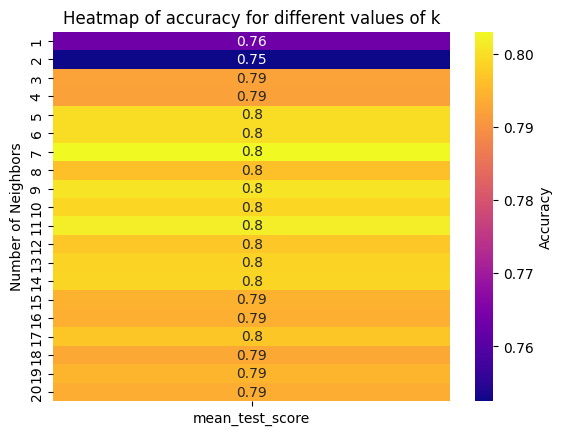

In [359]:
results = results.pivot_table(index='param_n_neighbors', columns=[], values='mean_test_score')
sns.heatmap(results, annot=True, cmap='plasma', cbar_kws={'label': 'Accuracy'})
plt.title('Heatmap of accuracy for different values ​​of k')
plt.ylabel('Number of Neighbors')
plt.show()

In [360]:
best_k = grid.best_params_['n_neighbors']
best_score = grid.best_score_
print(f"Mejor valor de k: {best_k}, Precisión: {best_score:.4f}")

Mejor valor de k: 7, Precisión: 0.8030


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Sigue estos pasos con el dataset de entrenamiento (_train_):

1. Entrena un clasificador KNN utilizando el mejor hiperparámetro que hayas encontrado.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.

Este proceso te permitirá ver cómo el hiperparámetro óptimo que has identificado mejora la efectividad de tu modelo KNN en la clasificación de los datos.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [361]:
knn_best=KNeighborsClassifier(n_neighbors=best_k).fit(X_train_projection, y_train)

In [362]:
y_train_pred_knn_best=knn_best.predict(X_train_projection) 
accuracy_score(y_train, y_train_pred_knn_best)

0.84575

In [363]:
y_pred_knn_best=knn_best.predict(X_test_projection) 
accuracy_score(y_test, y_pred_knn_best)

0.785

In [364]:
confusion_matrix(y_test, y_pred_knn_best)

array([[180,   0,  11,  18,   3],
       [  3, 171,   0,  10,   2],
       [  6,   0, 130,   0,  58],
       [ 11,   1,  10, 167,  16],
       [  1,   0,  55,  10, 137]])

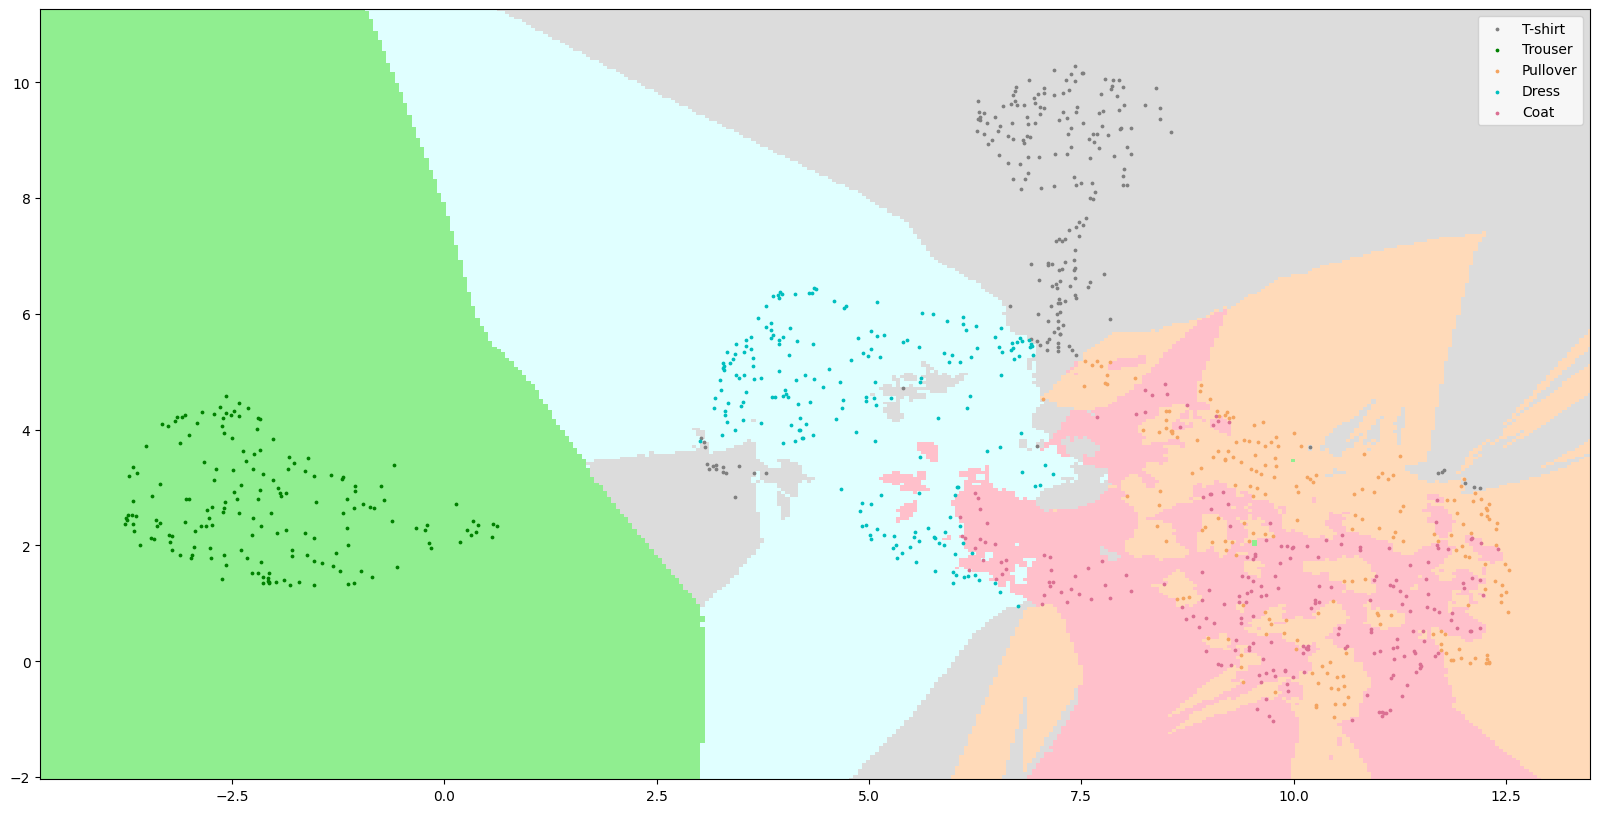

In [365]:
plot_decision_boundaries(knn_best, X_test_projection, y_pred_knn_best)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Comenta los resultados obtenidos en la búsqueda del mejor hiperparámetro. Reflexiona sobre cómo varió el rendimiento del modelo con los diferentes valores de `n_neighbors`.
2. Analiza cómo se visualiza gráficamente el cambio del valor de `n_neighbors`. ¿Observas alguna tendencia o patrón claro? ¿Es coherente esta diferencia entre los dos gráficos al cambiar el parámetro?
3. Examina las fronteras de decisión que has generado. ¿La forma de estas fronteras tiene sentido dado el algoritmo KNN utilizado? Piensa en cómo la elección del número de vecinos influye en la forma de la frontera.
4. Evalúa las predicciones realizadas sobre el conjunto de test. Observa su precisión y cómo se distribuyen en relación con las fronteras de decisión. ¿Son estas predicciones consistentes con lo que observas en las fronteras de decisión?

Este análisis te ayudará a comprender la eficacia del modelo KNN con diferentes configuraciones de `n_neighbors` y su impacto en la clasificación de los datos."
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

Durante la búsqueda del mejor hiperparametro de n_neighbors en KNN, se observó una mejora significativa en el rendimiento del modelo al aumentar n_neighbors de 2 a 7. Con k=2, la precisión fue de 0.732, mientras que con k=7, alcanzó 0.785. Finalmente, la mejor precisión en la búsqueda de hiperparámetros fue de 0.803. Este aumento sugiere que un mayor número de vecinos ayuda a suavizar la clasificación, reduciendo el posible sobreajuste. Sin embargo, en el conjunto de prueba, la precisión disminuyó ligeramente de 0.87825 a 0.84575 al aplicar k=7, lo que podría deberse a que un valor óptimo en validación no generaliza bien los datos.

Si analizamos ambas gráficas, lo que se busca al aumentar el valor de n_neighbors, es que las fronteras de decisión se vuelvan más suaves y menos complejas, tal y como ocurre al aumentar la k en la segunda figura. Con valores bajos de k (2), se ve que las fronteras son más irregulares y se ajustan más a los puntos de entrenamiento, lo que puede causar un sobreajuste. En cambio, con valores más altos (7), las fronteras se vuelven más lisas y reflejan mejor las tendencias globales del conjunto de datos. Esta tendencia es coherente con lo observado en el calculo de laprecisión, ya que ésta mejoró con un k mayor en validación, puesto que las fronteras menos complejas generalizan mejor.

Las fronteras de decisión en KNN dependen directamente del valor de n_neighbors. Com ose ve en la primera figura (k = 2), las fronteras son muy irregulares, siguiendo de cerca la distribución de los puntos de entrenamiento. Al aumentar k a 7, las fronteras se vuelven más suaves y permiten capturar mejor las divisiones generales entre las diferentes clases, aunque es cierto que sacrifican algunos detalles locales. 

Finalmente, las predicciones en el conjunto de test mejoraron al ajustar el hiperparámetro k. Antes de la optimización, con una precisión de 0.732, el modelo tenía fronteras de decisión más irregulares y ajustadas a los datos de entrenamiento. Al aplicar el hiperparametro (k=7), la precisión aumentó a 0.785, lo que indica que las fronteras de decisión se volvieron menos irregulares y generalizaron mejor. Este incremento muestra que el modelo con k=7 logró capturar mejor la estructura de los datos, a la vez que evitó detalles locales que podrían generar ruido en el modelo. Las predicciones son más consistentes con las fronteras observadas, puesto que reflejan un equilibrio adecuado entre complejidad y generalización.
</div>

<a id='ej14'></a>
## 1.5. SVM (1 punto)

En esta sección, vas a explorar las Máquinas de Vectores de Soporte (SVM), que se basan en el concepto del _Maximal Margin Classifier_ y el hiperplano.

Un hiperplano en un espacio p-dimensional se define como un subespacio plano y afín de dimensiones p-1. En dos dimensiones, es una recta; en tres, un plano convencional. Para dimensiones mayores a tres, aunque no es intuitivo visualizarlo, el concepto se mantiene.

Cuando los casos son perfectamente separables de manera lineal, surgen infinitos posibles hiperplanos. Para seleccionar el clasificador óptimo, utiliza el concepto de _maximal margin hyperplane_, el hiperplano que se encuentra más alejado de todas las observaciones de entrenamiento. Este se define calculando la distancia perpendicular mínima (margen) de las observaciones a un hiperplano. El hiperplano óptimo es aquel que maximiza este margen.

En el proceso de optimización, debes tener en cuenta que solo las observaciones al margen o que lo violan (vectores soporte) influyen en el hiperplano. Estos vectores soporte son los que definen el clasificador.

#### Los _kernels_ en SVM

En situaciones donde no puedes encontrar un hiperplano que separe dos clases, es decir, cuando las clases no son linealmente separables, puedes utilizar el truco del núcleo (_kernel trick_). Este método te permite trabajar en una dimensión nueva donde es posible encontrar un hiperplano para separar las clases.

Al igual que con el KNN, las SVM también dependen de varios hiperparámetros. En este caso, te enfocarás en optimizar dos hiperparámetros:

1. **C**: la regularización, que es el valor de penalización de los errores en la clasificación. Este valor indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar correctamente el máximo número de ejemplos. Debes probar los siguientes valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
   
2. **Gamma**: un coeficiente que multiplica la distancia entre dos puntos en el kernel radial. En términos simples, cuanto más pequeño sea gamma, más influencia tendrán dos puntos cercanos. Debes probar los valores: 0.001, 0.01, 0.1, 1 y 10.

Para validar el rendimiento del algoritmo con cada combinación de hiperparámetros, utiliza la validación cruzada (_cross-validation_) con 4 particiones estratificadas."

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>


1. Calcula el valor óptimo de los hiperparámetros _C_ y _gamma_ utilizando una búsqueda de rejilla con validación cruzada. Este proceso te ayudará a encontrar los valores óptimos.
2. Para cada combinación de valores, calcula su promedio y la desviación estándar.
3. Haz un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular los mejores hiperparámetros con el clasificador SVC (de `SVM` de `sklearn`). Para la visualización del _heatmap_, emplea la librería `Seaborn`.

Estos pasos te permitirán identificar de manera efectiva y visual los valores de _C_ y _gamma_ que maximizan la precisión de tu modelo SVM.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [366]:
parameters = {'C':[0.01, 0.1, 1, 10, 50, 100, 200], 'gamma': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedKFold(n_splits=4)
svc = SVC()
clf = GridSearchCV(svc, parameters, cv = cv).fit(X_train_projection, y_train)
svc_results = pd.DataFrame(clf.cv_results_)

In [367]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_gamma',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [368]:
results = svc_results[['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']]
results

,param_C,param_gamma,mean_test_score,std_test_score
0,0.01,0.001,0.39650,0.001500
1,0.01,0.010,0.71525,0.008496
2,0.01,0.100,0.75400,0.006782
3,0.01,1.000,0.76200,0.014283
4,0.01,10.000,0.20350,0.000500
5,0.10,0.001,0.71975,0.007327
6,0.10,0.010,0.76100,0.007583
7,0.10,0.100,0.76475,0.015073
8,0.10,1.000,0.79125,0.008408
9,0.10,10.000,0.80400,0.009618


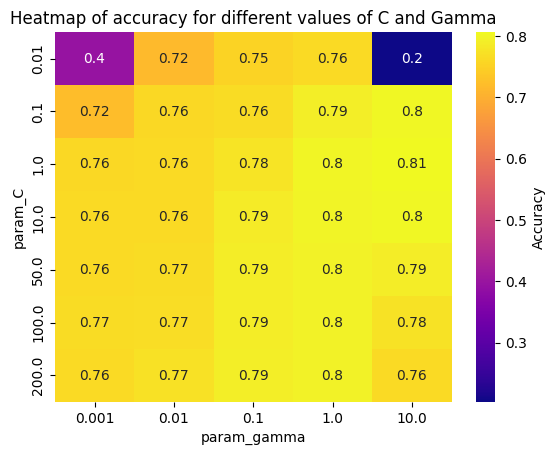

In [369]:
results = results.pivot_table(index='param_C', columns='param_gamma', values='mean_test_score')
sns.heatmap(results, annot=True, cmap='plasma', cbar_kws={'label': 'Accuracy'})
plt.title('Heatmap of accuracy for different values ​​of C and Gamma')
plt.show()

In [370]:
best_c = clf.best_params_['C']
best_gamma = clf.best_params_['gamma']
best_score = clf.best_score_
print(f"Mejor valor de C: {best_c}, Mejor valor de gamma: {best_gamma}, Precisión: {best_score:.4f}")

Mejor valor de C: 1, Mejor valor de gamma: 10, Precisión: 0.8065


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Realiza los siguientes pasos con el dataset de entrenamiento (_train_):

1. Entrena un modelo SVM utilizando la mejor combinación de parámetros que hayas encontrado.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.

Este proceso te permitirá ver cómo la mejor combinación de parámetros mejora la efectividad de tu modelo SVM en la clasificación de los datos.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [371]:
SVC_best = SVC(C = best_c, gamma = best_gamma).fit(X_train_projection, y_train)

In [372]:
y_train_pred_svc=SVC_best.predict(X_train_projection) 
accuracy_score(y_train, y_train_pred_svc)

0.84

In [373]:
y_pred_svc_best=SVC_best.predict(X_test_projection) 
accuracy_score(y_test, y_pred_svc_best)

0.791

In [374]:
confusion_matrix(y_test, y_pred_svc_best)

array([[176,   0,  10,  20,   6],
       [  1, 171,   0,  12,   2],
       [  4,   0, 134,   0,  56],
       [ 14,   1,   8, 166,  16],
       [  1,   0,  49,   9, 144]])

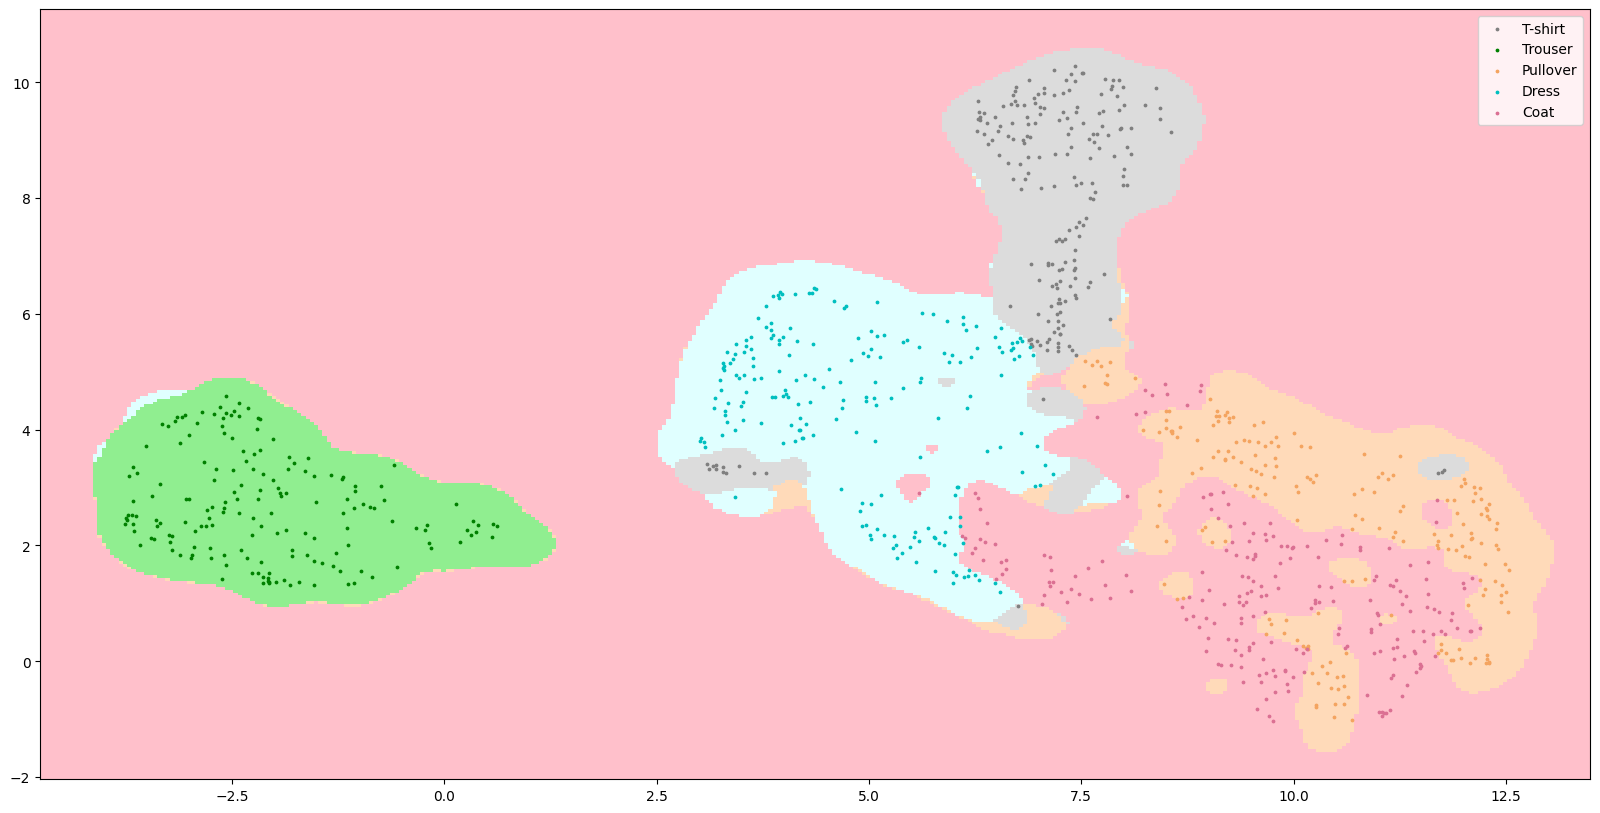

In [375]:
plot_decision_boundaries(SVC_best, X_test_projection, y_pred_svc_best)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Comenta los resultados obtenidos en la búsqueda de los mejores hiperparámetros. Reflexiona sobre cómo varió el rendimiento del modelo SVM con los diferentes valores de _C_ y _gamma_. Considera si los valores óptimos encontrados tienen sentido en el contexto de tu conjunto de datos.
2. Examina las fronteras de decisión que has generado con el modelo SVM. ¿La forma de estas fronteras es coherente con lo que esperarías del algoritmo utilizado? Piensa en cómo la combinación de hiperparámetros seleccionados podría influir en la forma de las fronteras.
3. Evalúa las predicciones realizadas sobre el conjunto de test. Observa su precisión y cómo se distribuyen en relación con las fronteras de decisión. ¿Son estas predicciones consistentes con lo que observas en las fronteras de decisión?

Este análisis te ayudará a comprender la eficacia del modelo SVM con los hiperparámetros seleccionados y su impacto en la clasificación de los datos."
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>


</div>

<a id='ej15'></a>
## 1.6. Árboles de decisión (1 punto)

En esta sección, vas a explorar los árboles de decisión, modelos predictivos que se basan en reglas binarias (si/no) para clasificar las observaciones según sus atributos y predecir el valor de la variable respuesta. Estos árboles pueden ser clasificadores, como en tu ejemplo, o regresores para predecir variables continuas.

#### Construcción de un Árbol

Para construir un árbol, sigue el algoritmo de *recursive binary splitting*:

1. Comienza en la parte superior del árbol, donde todas las observaciones pertenecen a la misma región.
2. Identifica todos los posibles puntos de corte para cada uno de los predictores. Estos puntos de corte son los diferentes niveles de los predictores.
3. Evalúa las posibles divisiones para cada predictor utilizando una medida específica. En los clasificadores, estas medidas pueden ser el *classification error rate*, el índice Gini, la entropía o el chi-square.

Comprender estos pasos te ayudará a entender cómo los árboles de decisión crean divisiones binarias para clasificar los datos y cómo estos pueden aplicarse tanto para clasificación como para regresión.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Sigue estos pasos:

1. Con el dataset de entrenamiento (_train_), entrena un árbol de decisión utilizando el clasificador `DecisionTreeClassifier` de la biblioteca `tree` de `sklearn`.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.
5. Representa el árbol de decisión. Puedes utilizar el comando `plot.tree` de la biblioteca `tree` de `sklearn`.

Estos pasos te permitirán evaluar cómo el árbol de decisión se comporta en tu conjunto de datos, tanto en términos de clasificación como en su representación visual."
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [376]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_projection, y_train)

DecisionTreeClassifier()

In [377]:
y_train_pred_tree=tree_clf.predict(X_train_projection) 
accuracy_score(y_train, y_train_pred_tree)

1.0

In [378]:
y_pred_tree=tree_clf.predict(X_test_projection) 
accuracy_score(y_test, y_pred_tree)

0.726

In [379]:
confusion_matrix(y_test, y_pred_tree)

array([[173,   1,  11,  21,   6],
       [  3, 169,   1,  12,   1],
       [  7,   1, 117,   2,  67],
       [ 17,   2,  13, 153,  20],
       [  3,   3,  74,   9, 114]])

c:\Users\USER\Desktop\OUC\Mi unidad\Aprendizaje Automático\Aprendizaje-Automatico\PEC3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


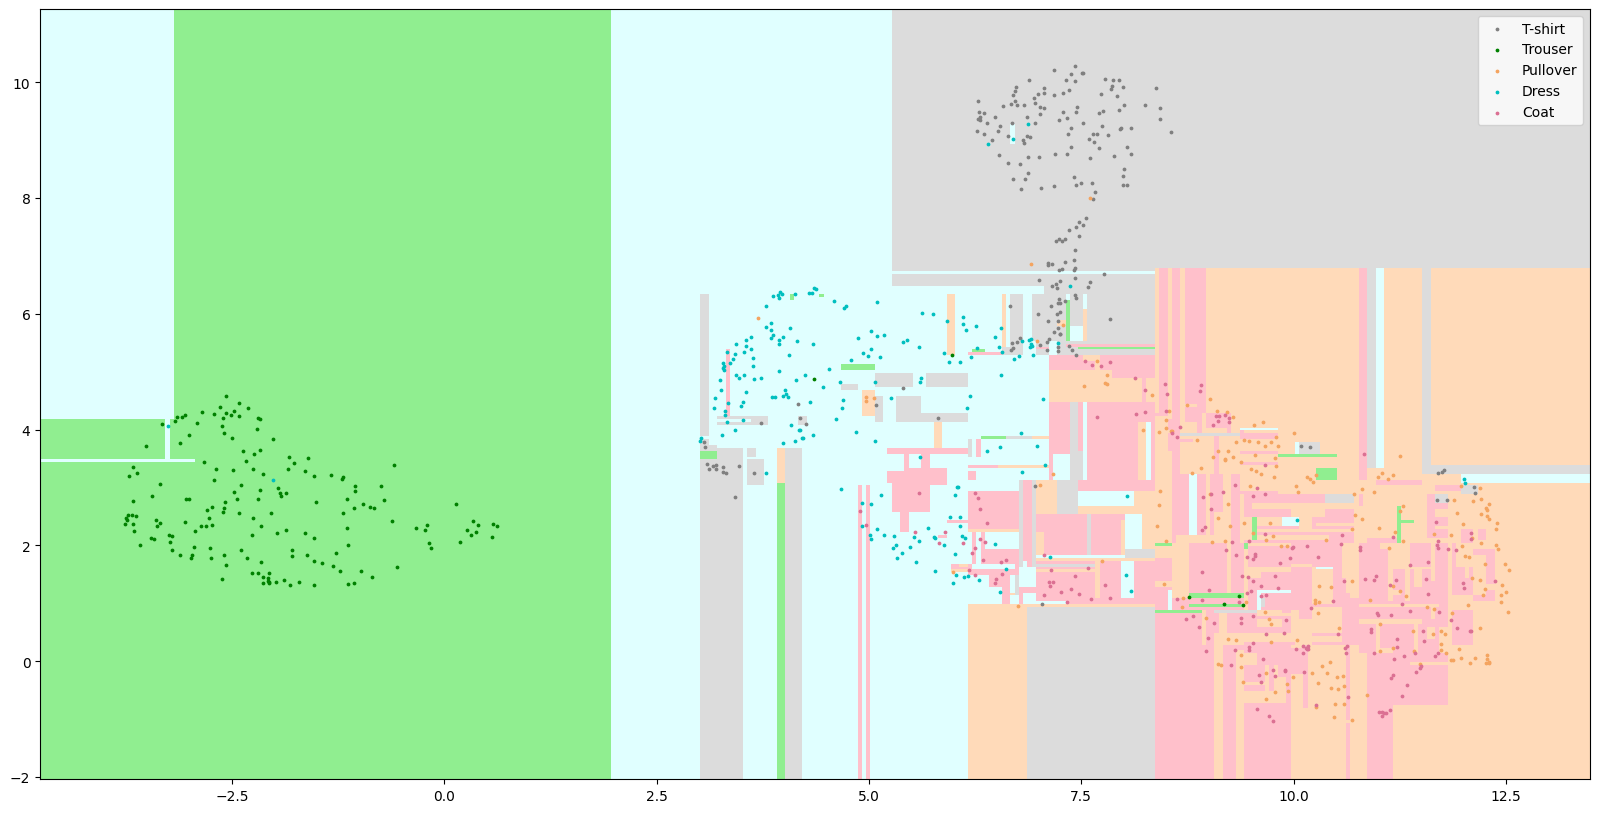

In [380]:
plot_decision_boundaries(tree_clf, X_test_projection, y_pred_tree)

[Text(0.28457755978463545, 0.9814814814814815, 'x[0] <= 1.977\ngini = 0.8\nsamples = 4000\nvalue = [788, 814, 806, 795, 797]'),
 Text(0.007085586425508111, 0.9444444444444444, 'x[1] <= 3.13\ngini = 0.018\nsamples = 777\nvalue = [0, 770, 0, 7, 0]'),
 Text(0.14583157310507178, 0.962962962962963, 'True  '),
 Text(0.0029834048107402573, 0.9074074074074074, 'x[1] <= 2.856\ngini = 0.004\nsamples = 564\nvalue = [0, 563, 0, 1, 0]'),
 Text(0.0014917024053701287, 0.8703703703703703, 'gini = 0.0\nsamples = 477\nvalue = [0, 477, 0, 0, 0]'),
 Text(0.004475107216110386, 0.8703703703703703, 'x[1] <= 2.857\ngini = 0.023\nsamples = 87\nvalue = [0, 86, 0, 1, 0]'),
 Text(0.0029834048107402573, 0.8333333333333334, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 1, 0]'),
 Text(0.005966809621480515, 0.8333333333333334, 'gini = 0.0\nsamples = 86\nvalue = [0, 86, 0, 0, 0]'),
 Text(0.011187768040275966, 0.9074074074074074, 'x[1] <= 3.134\ngini = 0.055\nsamples = 213\nvalue = [0, 207, 0, 6, 0]'),
 Text(0.0096960656

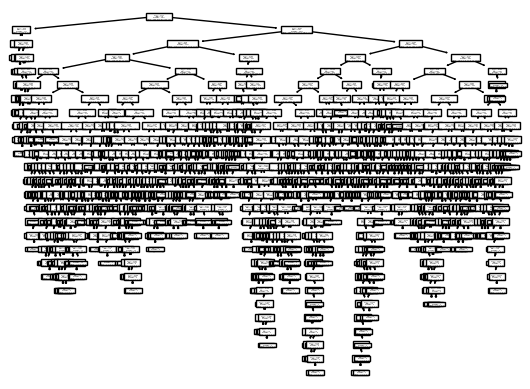

In [381]:
tree.plot_tree(tree_clf)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Evalúa y comenta los resultados obtenidos con el árbol de decisión. Considera tanto el _accuracy_ del modelo en los conjuntos de _train_ y _test_ como los resultados de la matriz de confusión.
2. Reflexiona sobre cómo la frontera de decisión visualizada en el conjunto de _test_ se alinea con los resultados obtenidos. ¿Es coherente con lo que esperarías de un árbol de decisión?
3. Observa la representación gráfica del árbol. Analiza cómo las diferentes ramificaciones y decisiones tomadas en el árbol explican el comportamiento del modelo y su impacto en la clasificación de los datos.

Este análisis te ayudará a comprender en profundidad el funcionamiento y la eficacia del árbol de decisión en tu conjunto de datos específico.

</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>


</div>

#### Evitando el *overfitting*

El proceso de construcción de árboles descrito tiende a reducir rápidamente el error de entrenamiento, por lo que generalmente el modelo se ajusta muy bien a las observaciones utilizadas como entrenamiento (conjunto de *train*). Como consecuencia, los árboles de decisión tienden al *overfitting*.
   
Para evitar el *overfitting* en los árboles de decisión, es crucial que modifiques ciertos hiperparámetros del modelo de la siguiente manera:

1. Utiliza el hiperparámetro `max_depth`, que define la profundidad máxima del árbol. Deberás explorar los valores entre 4 y 10 para encontrar el equilibrio adecuado entre la complejidad del modelo y su capacidad para generalizar.
2. Establece el hiperparámetro `min_samples_split`, que es el número mínimo de observaciones que debe tener una hoja del árbol antes de considerar una división. Experimenta con valores como 2, 10, 20, 50 y 100 para asegurarte de que el árbol no se vuelva demasiado específico para las observaciones de entrenamiento.

Ajustando estos hiperparámetros, podrás controlar la tendencia del árbol de decisión a sobreajustarse al conjunto de entrenamiento, mejorando así su capacidad para realizar predicciones efectivas en nuevos datos."

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong>

1. Calcula el valor óptimo de los hiperparámetros `max_depth` y `min_samples_split` utilizando una búsqueda de rejilla con validación cruzada. Este proceso te ayudará a encontrar los valores óptimos que evitarán el sobreajuste.
2. Para cada combinación de valores, calcula su promedio y la desviación estándar.
3. Haz un _heatmap_ para visualizar la precisión según los diferentes valores de los hiperparámetros.

Utiliza el módulo `GridSearchCV` de `sklearn` para calcular los mejores hiperparámetros con el clasificador `DecisionTreeClassifier` de `tree` de `sklearn`. Para la visualización del _heatmap_, emplea la librería `Seaborn`.

Estos pasos te permitirán identificar de manera efectiva y visual los valores de `max_depth` y `min_samples_split` que maximizan la precisión de tu árbol de decisión, minimizando el riesgo de sobreajuste.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [382]:
parameters = {'max_depth': np.arange(4,11), 'min_samples_split': [2,10,20,50,100]}
tree_cv = GridSearchCV(tree_clf, parameters).fit(X_train_projection, y_train)
svc_results = pd.DataFrame(tree_cv.cv_results_)

In [383]:
sorted(tree_cv.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_min_samples_split',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [384]:
results = svc_results[['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']]
results


,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
0,4,2,0.74900,0.015560
1,4,10,0.74900,0.015560
2,4,20,0.74900,0.015560
3,4,50,0.74900,0.015560
4,4,100,0.74925,0.015584
5,5,2,0.76775,0.012610
6,5,10,0.76775,0.012610
7,5,20,0.76850,0.013120
8,5,50,0.76850,0.013120
9,5,100,0.76900,0.013356


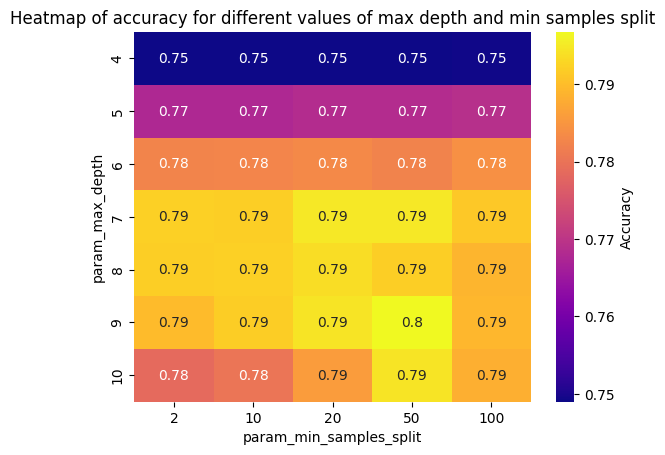

In [385]:
results = results.pivot_table(index='param_max_depth', columns='param_min_samples_split', values='mean_test_score')
sns.heatmap(results, annot=True, cmap='plasma', cbar_kws={'label': 'Accuracy'})
plt.title('Heatmap of accuracy for different values ​​of max depth and min samples split')
plt.show()

In [386]:
best_max_depth = tree_cv.best_params_['max_depth']
best_min_samples_split = tree_cv.best_params_['min_samples_split']
best_score = tree_cv.best_score_
print(f"Mejor valor de max_depth: {best_max_depth}, Mejor valor de min_samples_split: {best_min_samples_split}, Precisión: {best_score:.4f}")

Mejor valor de max_depth: 9, Mejor valor de min_samples_split: 50, Precisión: 0.7967


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>


1. Entrena un árbol de decisión con el dataset de entrenamiento (_train_) utilizando la mejor combinación de parámetros que hayas encontrado.
2. Calcula el _accuracy_ (precisión) del modelo tanto en los datos de _train_ como de _test_.
3. Calcula la matriz de confusión utilizando los datos de _test_.
4. Representa gráficamente la frontera de decisión con los datos de _test_.
5. Representa el árbol de decisión.

Estos pasos te permitirán evaluar cómo el árbol de decisión, ajustado con los hiperparámetros óptimos, se comporta en tu conjunto de datos, tanto en términos de clasificación como en su representación visual."
    
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [387]:
tree_clf_best = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split = best_min_samples_split)
tree_clf_best.fit(X_train_projection, y_train)

DecisionTreeClassifier(max_depth=np.int64(9), min_samples_split=50)

In [388]:
y_train_pred_tree_best=tree_clf_best.predict(X_train_projection) 
accuracy_score(y_train, y_train_pred_tree_best)

0.8405

In [389]:
y_pred_tree_best=tree_clf_best.predict(X_test_projection) 
accuracy_score(y_test, y_pred_tree_best)

0.772

In [390]:
confusion_matrix(y_test, y_pred_tree_best)

array([[181,   0,  10,  17,   4],
       [  1, 170,   0,  13,   2],
       [  4,   0, 121,   1,  68],
       [ 15,   1,   7, 166,  16],
       [  1,   0,  58,  10, 134]])

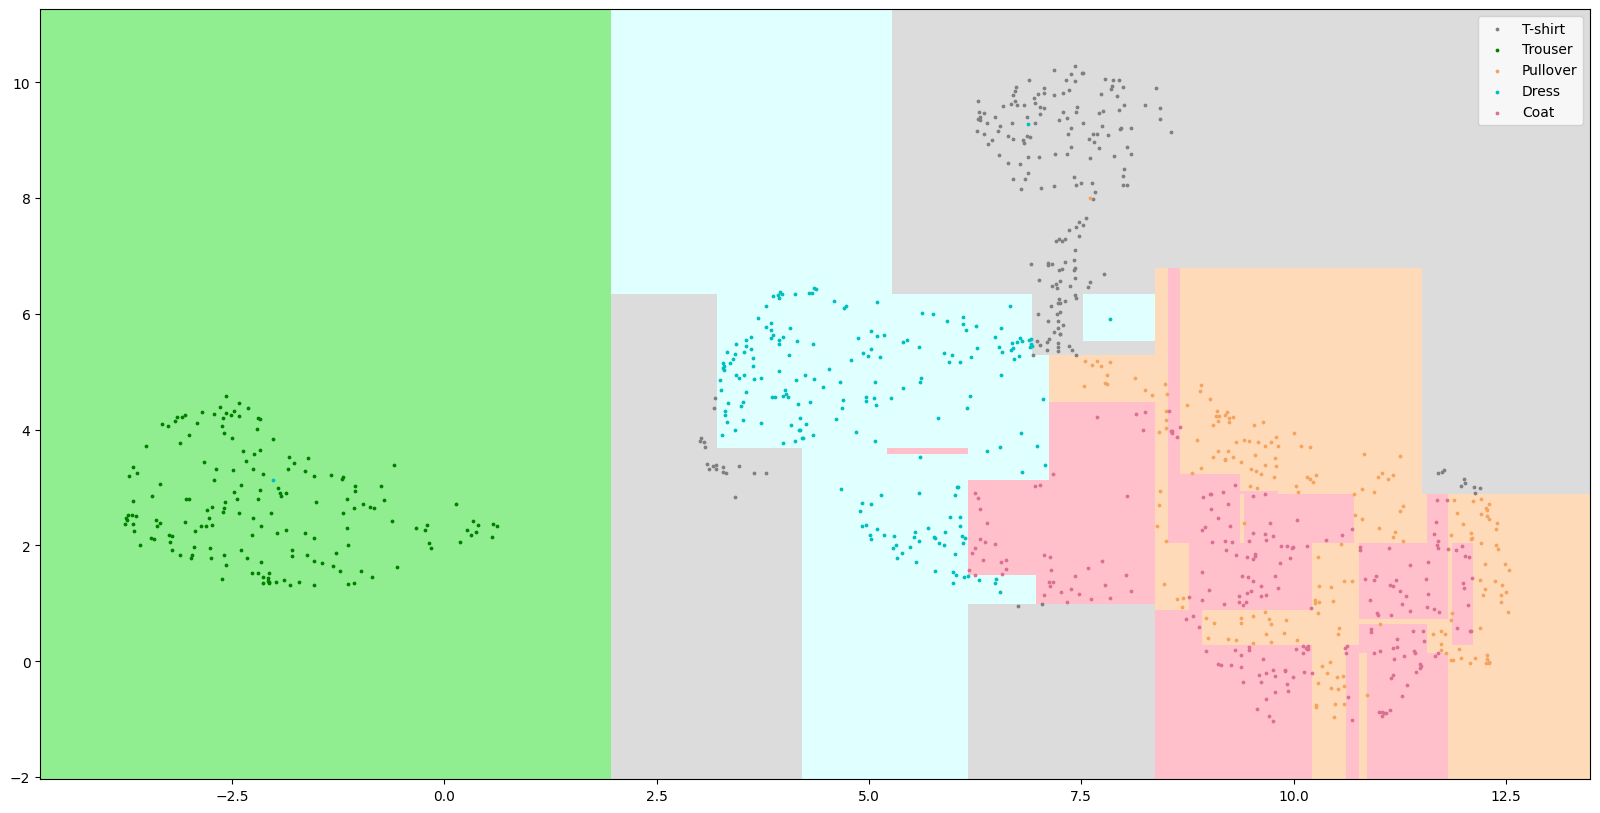

In [391]:
plot_decision_boundaries(tree_clf_best, X_test_projection, y_pred_tree_best)

[Text(0.28436117256637167, 0.95, 'x[0] <= 1.977\ngini = 0.8\nsamples = 4000\nvalue = [788, 814, 806, 795, 797]'),
 Text(0.03982300884955752, 0.85, 'x[1] <= 3.13\ngini = 0.018\nsamples = 777\nvalue = [0, 770, 0, 7, 0]'),
 Text(0.1620920907079646, 0.8999999999999999, 'True  '),
 Text(0.017699115044247787, 0.75, 'x[1] <= 2.856\ngini = 0.004\nsamples = 564\nvalue = [0, 563, 0, 1, 0]'),
 Text(0.008849557522123894, 0.65, 'gini = 0.0\nsamples = 477\nvalue = [0, 477, 0, 0, 0]'),
 Text(0.02654867256637168, 0.65, 'x[1] <= 2.857\ngini = 0.023\nsamples = 87\nvalue = [0, 86, 0, 1, 0]'),
 Text(0.017699115044247787, 0.55, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 1, 0]'),
 Text(0.035398230088495575, 0.55, 'gini = 0.0\nsamples = 86\nvalue = [0, 86, 0, 0, 0]'),
 Text(0.061946902654867256, 0.75, 'x[1] <= 3.134\ngini = 0.055\nsamples = 213\nvalue = [0, 207, 0, 6, 0]'),
 Text(0.05309734513274336, 0.65, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 1, 0]'),
 Text(0.07079646017699115, 0.65, 'x[0] <= -2.949\

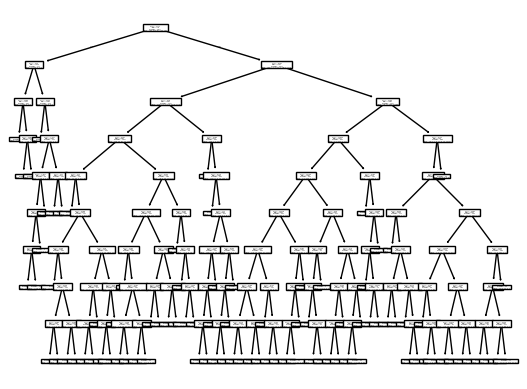

In [392]:
tree.plot_tree(tree_clf_best)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Evalúa y comenta los resultados obtenidos en la búsqueda de los mejores hiperparámetros. Considera cómo la combinación óptima de `max_depth` y `min_samples_split` ha impactado el rendimiento del árbol de decisión.
2. Examina las fronteras de decisión generadas con el conjunto de _test_. Reflexiona sobre si la forma de estas fronteras es coherente con lo que esperarías de un árbol de decisión configurado con estos hiperparámetros.
3. Analiza las predicciones realizadas sobre el conjunto de test. Observa su precisión y cómo se distribuyen en relación con las fronteras de decisión. ¿Son consistentes estas predicciones con la estructura del árbol de decisión y las fronteras observadas?

Este análisis te ayudará a comprender la eficacia del árbol de decisión con los hiperparámetros seleccionados y su impacto en la clasificación de los datos.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

Lo primero, aunque se muestran más arriba, señalar que los mejores hiperparámetros obtenidos para el caso de estudio son: max_depth = 9, min_samples_split = 50. 

Si analizamos la precisión del modelo, vemos que antes de optimizar el conjunto de entrenamiento tuvo una precisión de 1 (indicador de sobreajuste) y el test de 0.726. Sin embargo, una vez modelado con la combinación óptima de hiperparámetros, vemos que  el conjunto de entramiento disminuye su precisión hasta 0.8405, ya que no llega al sobreajuste como antes y el conjutno de test aumenta hasta una precisión de 0.772. Es decir, optimizar estos hiperparámetros ha reducido el sobreajuste significativamente. Antes de la optimización, esa precisión de 1 en el conjunto de entramiento nos indica que el modelo llegó a memorizar los datos, pero que no podía generalizar el conjunto de test. Por otro lado, con los hiperparámetros ajustados, la precisión en el conjunto de entrenamiento es más realista (0.8405) y la precisión en el conjunto de test ha mejorado (0.772), indicando que el modelo es capaz de generalizar mejor.

Con los hiperparámetros optimizados lo que se ha hecho es reducir las fronteras sobreajustadas obtenidas en el primer modelo sin ajustar, siendo éstas menos complejas. Esto tiene sentido porque hemos capado la profundidad máxima del árbol (max_depth = 9) y la restricción en la división mínima (min_samples_split = 50) limitando la complejidad del modelo y reduciendo el sobreajuste. L oque se ve en la segunda figura (modelo ajustado) es un árbol de decisión con regiones más amplias y menos específicas, ya que al haber "podado" el árbol, se han simplificado las decisiones. Por otro lado, esto también nos lo indica la matriz de confusión, ya que  en la matriz del modelo optimizado, se ve una reducción de errores de clasificación, aunque siguen persistentes los errores de las clases que tienen solapamiento en los datos, al igual que hemos visto en modelos anteriores. 
</div>

<a id='eje2'></a>
# 2. Implementación del caso práctico (5 puntos)

Hoy en día, la logística de la última milla es un problema abordado en la industria por muchas empresas dedicadas al comercio electrónico. La información proporcionada al usuario a la hora de realizar un pedido puede suponer un valor diferencial. Por ello, muchas empresas dedican muchos recursos para dar una estimación precisa sobre el tiempo que va a tardar en llegar cada pedido. En este ejercicio nos vamos a centrar en predecir el nivel de servicio de las operaciones logísticas de última milla de Amazon. En concreto identificaremos aquellas entregas que se consideren premium (tiempo de reparto inferior a dos horas).

Para ello, vamos a utilizar el conjunto de datos de entregas [amazon-delivery-dataset](https://www.kaggle.com/datasets/sujalsuthar/amazon-delivery-dataset), el cual incluye datos sobre más de 43.632 entregas en varias ciudades, con información relevante sobre los detalles del pedido, los agentes de entrega, las condiciones meteorológicas y del tráfico, y las métricas de rendimiento de la entrega. En concreto, el dataset contiene 16 características:

- Order_ID: identificador único de pedido
- Agent_Age: edad del agente (repartidor)
- Agent_Rating: puntuación del agente (repartidor)
- Store_Latitude: latitud del almacén o tienda
- Store_Longitude: longitud del almacén o tienda
- Drop_Latitude: latitud del cliente
- Drop_Longitude: longitud del cliente
- Order_Date: fecha del pedido
- Order_Time: hora del pedido 
- Pickup_Time: hora a la que el pedido fue recogido para su entrega
- Weather: información sobre la climatología
- Traffic: información sobre el tráfico
- Vehicle: información sobre el vehículo
- Area: información sobre el área de reparto
- Category: categoría de los productos del pedido
- Delivery_Time: tiempo de reparto (minutos)

El objetivo de esta sección es abordar el análisis de este conjunto de datos y entrenar una red neuronal (Perceptrón Multicapa) para predecir el nivel de servicio. Aquí tienes algunos pasos que podrías seguir:

1. **Análisis Exploratorio de Datos (EDA)**: Comienza explorando el conjunto de datos para comprender su estructura y distribución. Analiza la proporción de cada clase. Observa la distribución de las diferentes características y su relación con la clase objetivo "class".

2. **Preprocesamiento de Datos**: Considera normalizar las características para que estén en la misma escala que las componentes principales.

3. **Modelización**: Utiliza un perceptrón multicapa como herramienta de clasificación. Dado que el objetivo es identificar el nivel de servicio de la entrega, es vital centrarse en métricas como la precisión, la sensibilidad (recall), el valor F1 y el área bajo la curva ROC (AUC-ROC).

4. **Evaluación**: Realiza una evaluación y análisis riguroso del rendimiento de tu modelo.

Este enfoque integral te permitirá no solo construir un modelo efectivo sino también comprender mejor las características subyacentes del nivel de servicio en el conjunto de datos.

<a id='ej20'></a>
## 2.1. Carga de datos y procesamiento inicial (0.5 puntos)

Lo primero que debes hacer es cargar el conjunto de datos y visualizar información relevante del mismo. Asegúrate de verificar lo siguiente:

1. Confirma la cantidad total de filas y columnas en el DataFrame.
2. Revisa el nombre de cada columna del DataFrame.
3. Verifica el número de valores no nulos en cada columna.
4. Identifica el tipo de datos de cada columna, que puede ser int, float, object, entre otros.
5. Comprueba la cantidad de memoria utilizada por el DataFrame.

Estos pasos te proporcionarán una comprensión inicial clara y detallada del conjunto de datos con el que estás trabajando.

In [498]:
root_path = kagglehub.dataset_download("sujalsuthar/amazon-delivery-dataset")
dataset_path = os.path.join(root_path, "amazon_delivery.csv") 
data = pd.read_csv(dataset_path)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Cómo se puede observar, no disponemos del nivel de servicio en el conjunto de datos. Por ello, vamos a definir que todas las entregas realizadas en un máximo de dos horas han tenido un servicio Premium. Para ello, crea una nueva columna denominada "Premium_Delivery", que contenga el valor 1 si la entrega se ha realizado en un máximo de 120 minutos, y un 0 en caso contrario. Es importante asegurar que el tipo de la nueva columna sea entero.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [499]:
data['Premium_Delivery'] = data['Delivery_Time'].apply(lambda x: 1 if x<=120 else 0)

In [500]:
data['Premium_Delivery'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 43739 entries, 0 to 43738
Series name: Premium_Delivery
Non-Null Count  Dtype
--------------  -----
43739 non-null  int64
dtypes: int64(1)
memory usage: 341.8 KB


In [501]:
data['Premium_Delivery'].value_counts()

Premium_Delivery
0    22392
1    21347
Name: count, dtype: int64

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Para simplificar el ejercicio y facilitar su comprensión, se deben eliminar las siguientes columnas: Order_ID, Order_Date, Order_Time y Pickup_Time
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [502]:
data.drop(['Order_ID', 'Order_Date', 'Order_Time', 'Pickup_Time'], axis = 1, inplace = True)

In [503]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Agent_Age         43739 non-null  int64  
 1   Agent_Rating      43685 non-null  float64
 2   Store_Latitude    43739 non-null  float64
 3   Store_Longitude   43739 non-null  float64
 4   Drop_Latitude     43739 non-null  float64
 5   Drop_Longitude    43739 non-null  float64
 6   Weather           43648 non-null  object 
 7   Traffic           43739 non-null  object 
 8   Vehicle           43739 non-null  object 
 9   Area              43739 non-null  object 
 10  Delivery_Time     43739 non-null  int64  
 11  Category          43739 non-null  object 
 12  Premium_Delivery  43739 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 4.3+ MB


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
    
A continuación, vamos a calcular la distancia harvesiana en kilómetros entre el almacén y el cliente. Para ello, debemos crear un nueva columna "Distance" y eliminar las cuatro columnas relacionadas con las coordenadas.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [504]:
data['Distance'] = 0
for index, row in data.iterrows():
    store = [row['Store_Latitude'], row['Store_Longitude']]
    drop = [row['Drop_Latitude'], row['Drop_Longitude']]
    store_radians = [radians(coord) for coord in store]
    drop_radians = [radians(coord) for coord in drop]
    distance = haversine_distances([store_radians, drop_radians])  * 6371
    data.at[index,'Distance'] = distance[0][1]


C:\Users\USER\AppData\Local\Temp\ipykernel_17632\3466159109.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.0251492856775037' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[index,'Distance'] = distance[0][1]


In [505]:
data.drop(['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude'], axis = 1, inplace = True)

In [506]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Agent_Age         43739 non-null  int64  
 1   Agent_Rating      43685 non-null  float64
 2   Weather           43648 non-null  object 
 3   Traffic           43739 non-null  object 
 4   Vehicle           43739 non-null  object 
 5   Area              43739 non-null  object 
 6   Delivery_Time     43739 non-null  int64  
 7   Category          43739 non-null  object 
 8   Premium_Delivery  43739 non-null  int64  
 9   Distance          43739 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 3.3+ MB


In [507]:
data.columns

Index(['Agent_Age', 'Agent_Rating', 'Weather', 'Traffic', 'Vehicle', 'Area',
       'Delivery_Time', 'Category', 'Premium_Delivery', 'Distance'],
      dtype='object')

In [508]:
data = data.reindex(['Agent_Age', 'Agent_Rating', 'Weather', 'Traffic', 'Vehicle', 'Area',
       'Delivery_Time', 'Category', 'Distance', 'Premium_Delivery'], axis=1,)

In [509]:
data.head()

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Premium_Delivery
0,37,4.9,Sunny,High,motorcycle,Urban,120,Clothing,3.025149,1
1,34,4.5,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530,0
2,23,4.4,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758,0
3,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401,1
4,32,4.6,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138,0


<a id='ej21'></a>
## 2.2. Análisis Exploratorio de Datos (EDA) (1.25 puntos)

El Análisis Exploratorio de Datos (EDA, por sus siglas en inglés) en ciencia de datos es un enfoque inicial para comprender y resumir el contenido de un conjunto de datos. Este proceso implica varias técnicas y pasos:

1. **Inspección de Datos**: Se comienza por revisar los datos brutos para identificar su estructura, tamaño y tipo (como numérico, categórico). Esto incluye detectar valores faltantes o inusuales.

2. **Resumen Estadístico**: Se calculan estadísticas descriptivas como la media, mediana, rango, varianza y desviación estándar para obtener una idea general de las tendencias y patrones en los datos.

3. **Visualización de Datos**: Se utilizan gráficos y diagramas (como histogramas, gráficos de caja, diagramas de dispersión) para visualizar distribuciones, relaciones entre variables y posibles anomalías. Esto ayuda a comprender mejor los datos y a identificar patrones o irregularidades.

4. **Análisis de Relaciones y Correlaciones**: Se exploran las relaciones entre diferentes variables para entender cómo se influencian entre sí. Esto puede implicar el uso de matrices de correlación y gráficos de dispersión.

5. **Identificación de Patrones y Anomalías**: Se buscan patrones consistentes o anomalías (como valores atípicos) que puedan sugerir tendencias o problemas en los datos.

El EDA es una fase crítica en cualquier proyecto de ciencia de datos, ya que proporciona una comprensión profunda y una base sólida para posteriores análisis y modelado.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

1. Calcula las frecuencias de la variable objetivo (`Premium_Delivery`) en tu conjunto de datos. 
2. Crea un gráfico de barras para visualizar estas frecuencias. Esto te ayudará a entender la proporción de entregas premium en comparación con las que no lo son.

A continuación, analiza la distribución de las variables numéricas:

1. Representa gráficamente el histograma de las variables, separando las observaciones según la clase a la que pertenecen (premium o no).
2. Organiza todos los histogramas en un formato de 4 filas y 1 columna. Esto facilitará la comparación visual de las distribuciones para cada clase en cada variable.

Por último, analiza la distribución de las variables categóricas de forma análoga a las variables numéricas, organizando todos los histogramas en un formato de 5 filas y 1 columna.

Estos pasos te permitirán obtener una visión más clara de la estructura de tu conjunto de datos y cómo las diferentes variables pueden influir en la identificación de las entregas premium.
    </div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [510]:
data['Premium_Delivery'].value_counts()

Premium_Delivery
0    22392
1    21347
Name: count, dtype: int64

In [511]:
def categoricos_objetivo(df, objetivo):
    """
    Esta función grafica la distribución de todas las variables categóricas que existen en un dataframe mediante gráfica de barras verticales 
    comparando por la variable objetivo
    :param df: (DataFrame) el dataframe del cual se quieren graficar todas las variables categóricas
    :param  objetivo: (DataFrame) el dataframe de la variable objetivo
    :return imagen: una imagen con todas las distribuciones posibles
    """ 
    
    categoricas = df.select_dtypes('O')

    filas = len(categoricas.columns)
    fig, ax = plt.subplots(nrows=filas, ncols=1, figsize=(8, filas * 6))
    ax = ax.flat

    for posicion, columna in enumerate(categoricas.columns):
        categories = df[columna].unique()
        valor_objetivo = df[objetivo].unique()
        
        bar_width = 0.35
        num_categorias = np.arange(len(categories))
        colores = {0: 'PLUM', 1: '#6FD08C'}

        for i, valor in enumerate(valor_objetivo):
            valores = df[df[objetivo] == valor][columna].value_counts().reindex(categories, fill_value=0)
            valores_normalizados = valores /valores.sum() #Normalización de los resultados para su comparativa
            color = colores.get(valor)
            ax[posicion].bar([num + bar_width * i for num in num_categorias], valores_normalizados, bar_width, label=valor, color=color, edgecolor='black')
        
        ax[posicion].set_xlabel(columna, fontsize=12)
        ax[posicion].set_ylabel('Relative Frequency', fontsize=12)
        ax[posicion].set_title(f'{columna} by {objetivo}', fontsize=14, fontweight='bold')
        ax[posicion].set_xticks([num + bar_width * (len(valor_objetivo) - 1) / 2 for num in num_categorias])
        ax[posicion].set_xticklabels(categories, rotation=30, horizontalalignment = 'right')
        ax[posicion].legend()

    plt.tight_layout()
    plt.show()

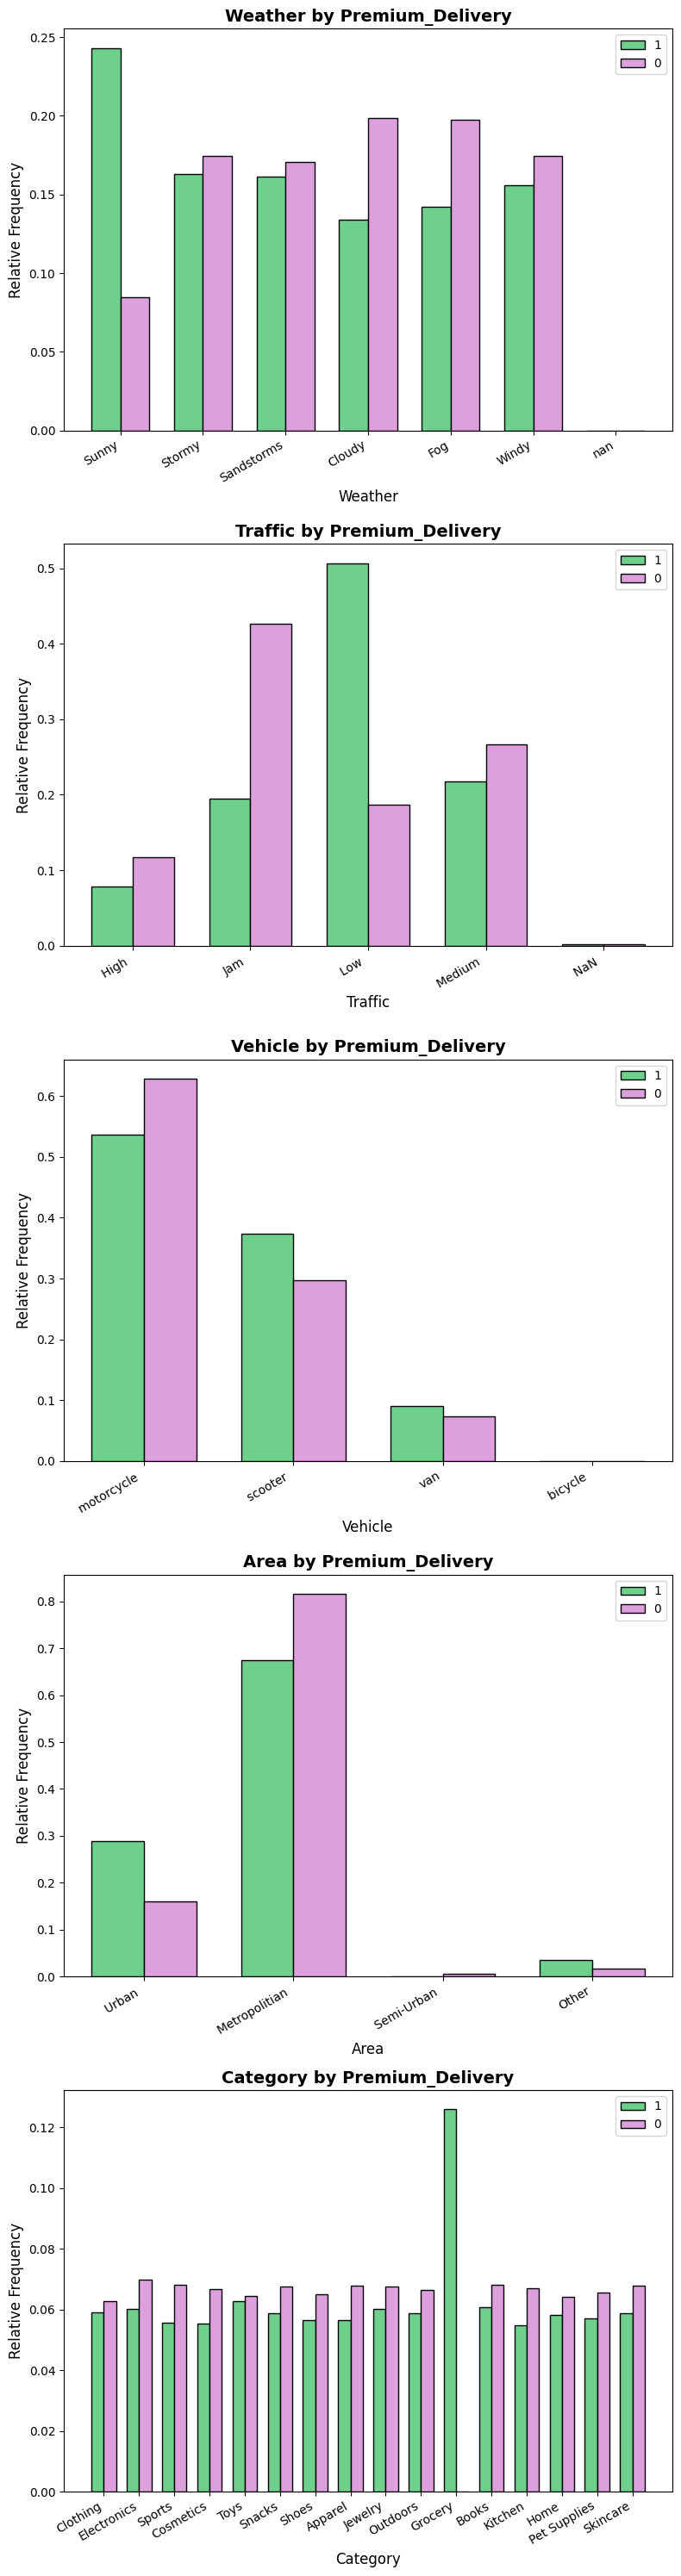

In [512]:
categoricos_objetivo(data, 'Premium_Delivery')

In [513]:
def numericos_objetivo(df, objetivo):
    """
    Esta función grafica la distribución de todas las variables numéricas que existen en un dataframe mediante gráfica de area
    comparando por la variable objetivo
    :param df: (DataFrame) el dataframe del cual se quieren graficar todas las variables numéricas
    :param  objetivo: (DataFrame) el dataframe de la variable objetivo
    :return imagen: una imagen con todas las distribuciones posibles
    """     
    numericos = df.select_dtypes('number')

    filas = len(numericos.columns[:-1])
    fig, ax = plt.subplots(nrows=filas, ncols=1, figsize=(8, filas * 6))
    ax = ax.flat

    for posicion, columna in enumerate(numericos.columns[:-1]):

        tabla_frecuencia = pd.crosstab(df[columna], df[objetivo])
        
        tabla_frecuencia.plot(kind = 'area', alpha=0.5, stacked=False, color=['PLUM', '#6FD08C'], figsize=(14,20), ax = ax[posicion])
        
        ax[posicion].set_title(f'{columna}', fontsize=14)
        ax[posicion].set_xlabel(columna, fontsize=12)
        ax[posicion].set_ylabel('Frequency', fontsize=12)
        ax[posicion].legend() 

    plt.tight_layout()
    plt.show()

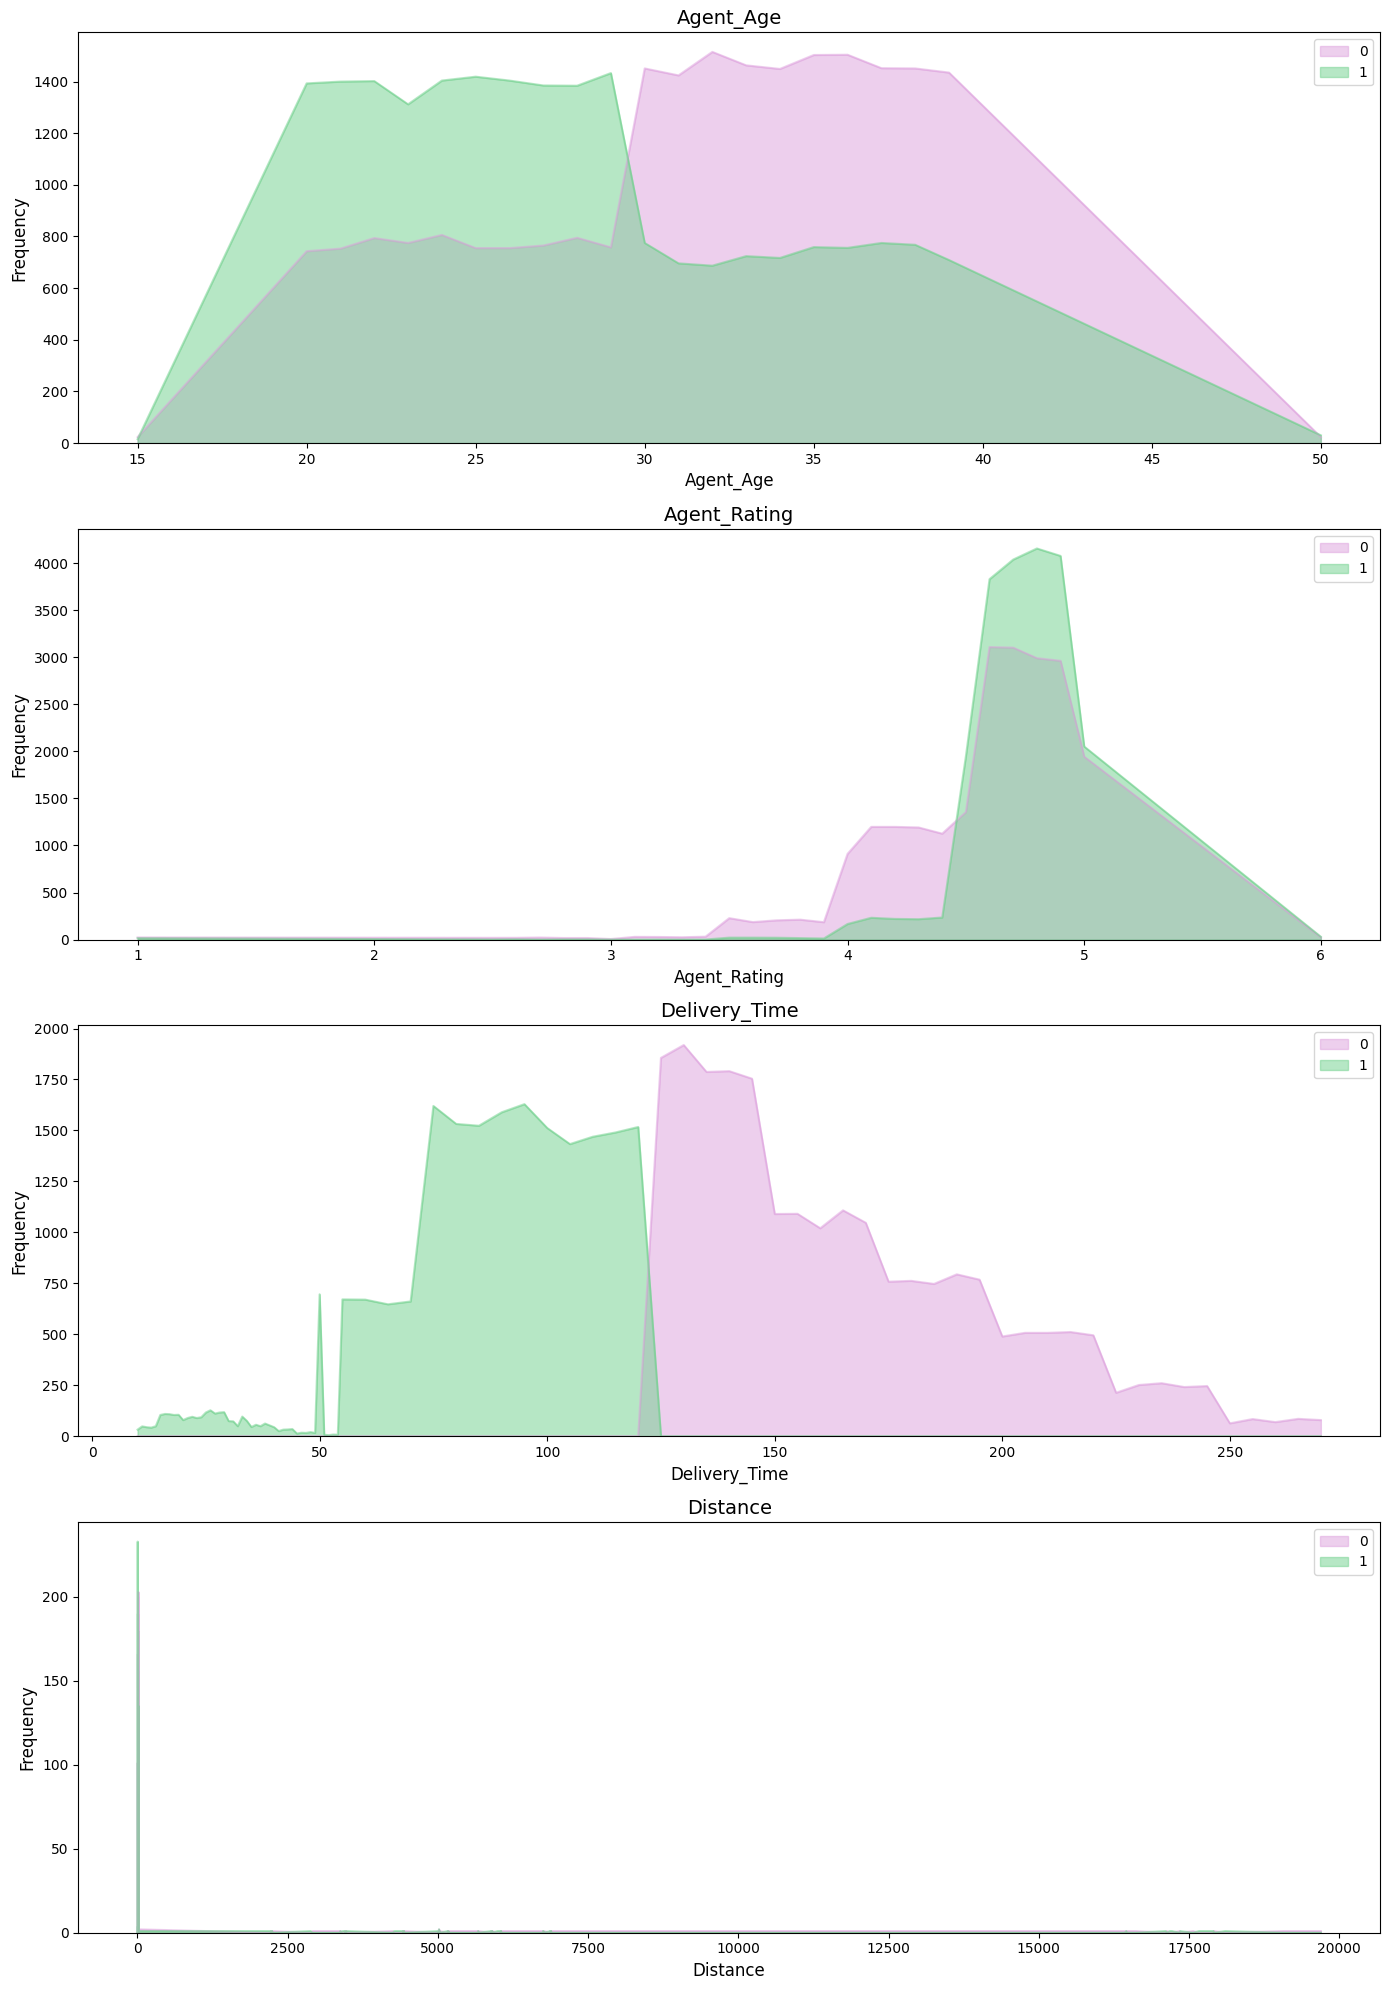

In [514]:
numericos_objetivo(data, 'Premium_Delivery')

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

1. Evalúa la relación de las frecuencias de la variable `Premium_Delivery`. Reflexiona sobre cómo se distribuyen las transacciones entre premium y no no premium. ¿Es la distribución significativamente desigual? ¿Qué implica esto para el análisis y la modelización de los datos?
2. Analiza la información proporcionada por los histogramas de las variables descriptoras. Observa si hay diferencias notables en las distribuciones de estas variables entre las clases. Pregúntate: ¿Hay variables que muestren patrones distintos para el nivel de servicio?
3. Considera si hay otras formas de visualización que podrían ser útiles para entender mejor los datos. Por ejemplo, ¿serían útiles los diagramas de caja (boxplots) para visualizar la distribución de las variables en ambas clases? ¿Podría un mapa de calor de la matriz de correlación entre variables ayudarte a entender las relaciones entre ellas?

Este análisis te ayudará a obtener una comprensión más profunda de la naturaleza de tus datos y a identificar posibles características que podrían ser importantes para detectar las entregas premium.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

Analizando las frecuencias de la viarable Premium_Delivery, podemos ver que tienen valores basntate parejos, puesto que el "0" (No) son 22392 registros y el "1" (Si) son 21347 registros. Es una variable objetivo casi equilibrada. Esto puede ayudarnos en la modelización puesto que evitaremos el desbalanceo entre las distintas clases, que pueden sesgar el modelo.

Respecto a las variables descriptoras: 

1. Weather: Se puede ver que en general las entregas no premium son superiores a las premium aunque no mucho, excepto cuando son días soleados, donde se ve que las entregas premium son muy superiores a las no premium. 

2. Traffic: Como es de esperar, las entregas premium son mucho mayores en condiciones de tráfico bajo. Sin embargo, con mucho tráfico, las frecuencias son similares entre premium y no premium, y en el caso de que haya retenciones, las frecuencias no premium se disparan. 

3. Vehicle: Las motocicletas son más utilizadas para entregas premium, mientras que las scooters tienen una mayor proporción en no premium y el uso de furgonetas es bajo para ambos tipos de entrega. El tipo de vehículo parece que es clave y que influye en las entregas premium.

4. Area: Las entregas premium son más frecuentes en áreas metropolitanas, aunque la proporción en áreas urbanas es significativa para ambas clases. Sin embargo, en áreas semiurbanas y otras regiones, la frecuencia es baja en general. 

5. Category: Las entregas premium se ven destacadas en la categoría de grocery (tiendas de comida), lo cual es un patrón claro. En las demás categorías, las diferencias entre premium y no premium son menos pronunciadas. 

6. Agent_Age: Parece que la edad es un factor determinante en la entrega premium, ya que los agentes más jóvenes (< 30 años) están asociados más frecuentemente con entregas premium.

7. Agent_Rating: Tanto las entregas premium como las no premium tienen un pico alrededor de una calificación de 4.5 a 5. Sin embargo, las entregas premium tienen una frecuencia ligeramente mayor en las calificaciones más altas (alrededor de 5). Esto puede deberse a que los agentes con calificaciones más altas son más propensos a proporcionar entregas premium, lo cual tiene sentido porque se presupone que un mejor rendimiento está vinculado a un mejor servicio.

8. Delivery_Time: Esta variable es la precursora de si una entrega es premium o no, puestoque la condición de que una entrega sea premium es que tenga un tiempo de entrega menor a 120 min, por lo cual tiene sentido que en la distribución aparezcan todas las entregas premium por debajo de los 120 min y las no premium por encima de dicho tiempo.

9. Distance: La mayoría de las entregas se concentran en distancias cortas y la gráfica parece no diferenciar significativamente entre entregas premium y no premium. 

Respecto a la implementación de otras formas de visualización, éstas nos permitirian detectar patrones distintos que nos vemos con un simple histograma, veríamos si hay relaciones entre las variables numéricas y categóricas y podríamos elegir mejor las variables que utilizaremos en el entrenamiento del modelo. Para mejorar el análisis de las nueve variables presentadas, es fundamental explorar diferentes técnicas de visualización más allá de los histogramas. Los diagramas de caja (boxplots) son clave para identificar la distribución de los datos y detectar outliers, especialmente en variables como Agent_Age, Agent_Rating, Delivery_Time, y Distance, lo que permite observar diferencias de dispersión entre entregas premium y no premium. Los mapas de calor (heatmaps) pueden revelar correlaciones importantes entre variables numéricas, como Delivery_Time y Agent_Rating, destacando posibles relaciones lineales o multicolinealidad. Los gráficos de dispersión son útiles para analizar combinaciones de variables continuas, como Distance vs. Delivery_Time, mostrando tendencias o patrones en función del servicio premium. Para las variables categóricas, los gráficos de barras apiladas permiten visualizar la proporción de entregas premium en cada categoría, como Weather, Traffic o Vehicle, mientras que los gráficos de violín ofrecen una visión más detallada de las distribuciones en variables numéricas. Por lo que sí, se pueden implementar otras visualizaciones para aportar más información a la exploración de los datos.
</div>

<a id='ej22'></a>
## 2.3. Preprocesamiento de Datos (1.25 puntos)

El preprocesamiento de datos en ciencia de datos es un paso crucial que involucra la preparación y transformación de datos brutos en un formato adecuado para su posterior análisis y modelado. Este proceso incluye varias tareas esenciales:

1. **Limpieza de Datos**: Se eliminan o corrigen datos erróneos, incompletos, inexactos o irrelevantes. Esto puede incluir tratar con valores faltantes, corregir errores de entrada y manejar outliers.

2. **Normalización y Escalado**: Los datos se transforman para que estén en una escala común, sin distorsionar diferencias en los rangos de valores ni perder información. Por ejemplo, escalado min-max o estandarización.

3. **Codificación de Variables Categóricas**: Las variables categóricas (como género o país) se convierten en formatos numéricos para que puedan ser procesadas por algoritmos de aprendizaje automático, utilizando técnicas como codificación one-hot o codificación de etiquetas.

4. **División de Datos**: Los datos se dividen en conjuntos de entrenamiento, validación y prueba, permitiendo entrenar modelos, afinar hiperparámetros y evaluar el rendimiento del modelo de manera efectiva.

5. **Manejo de Datos Desbalanceados**: En casos de conjuntos de datos desbalanceados, se aplican técnicas como sobremuestreo o submuestreo para asegurar que el modelo no esté sesgado hacia la clase más frecuente.

6. **Ingeniería de Características**: Se crean nuevas variables (características) a partir de los datos existentes para mejorar la capacidad del modelo para aprender patrones y hacer predicciones.

El preprocesamiento es esencial para mejorar la calidad de los datos y hacerlos más adecuados y efectivos para análisis y modelado en proyectos de ciencia de datos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> elimina los atributos categóricos del conjunto de datos y en su lugar introduce la transformación de dichos atributos a tantas variables binarias como categorías tengan. Es importante que las nuevas columnas generadas sean de tipo entero. Recuerda que la codificación one-hot convierte las etiquetas categóricas en vectores binarios. En estos vectores, el valor de 1 se asigna a la posición correspondiente a la clase y el valor de 0 a todas las demás posiciones. Esto facilita que los modelos de aprendizaje automático procesen y entiendan las etiquetas categóricas.
<hr>
Sugerencia: utilizad la función "get_dummies" de "pandas".

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [515]:
data.select_dtypes('O').columns

Index(['Weather', 'Traffic', 'Vehicle', 'Area', 'Category'], dtype='object')

In [516]:
data_dummie = pd.get_dummies(data, data.select_dtypes('O').columns, dtype=int)

In [517]:
data_dummie.columns

Index(['Agent_Age', 'Agent_Rating', 'Delivery_Time', 'Distance',
       'Premium_Delivery', 'Weather_Cloudy', 'Weather_Fog',
       'Weather_Sandstorms', 'Weather_Stormy', 'Weather_Sunny',
       'Weather_Windy', 'Traffic_High ', 'Traffic_Jam ', 'Traffic_Low ',
       'Traffic_Medium ', 'Traffic_NaN ', 'Vehicle_bicycle ',
       'Vehicle_motorcycle ', 'Vehicle_scooter ', 'Vehicle_van',
       'Area_Metropolitian ', 'Area_Other', 'Area_Semi-Urban ', 'Area_Urban ',
       'Category_Apparel', 'Category_Books', 'Category_Clothing',
       'Category_Cosmetics', 'Category_Electronics', 'Category_Grocery',
       'Category_Home', 'Category_Jewelry', 'Category_Kitchen',
       'Category_Outdoors', 'Category_Pet Supplies', 'Category_Shoes',
       'Category_Skincare', 'Category_Snacks', 'Category_Sports',
       'Category_Toys'],
      dtype='object')

In [518]:
data_dummie.head()

,Agent_Age,Agent_Rating,Delivery_Time,Distance,Premium_Delivery,Weather_Cloudy,Weather_Fog,Weather_Sandstorms,Weather_Stormy,Weather_Sunny,...,Category_Home,Category_Jewelry,Category_Kitchen,Category_Outdoors,Category_Pet Supplies,Category_Shoes,Category_Skincare,Category_Snacks,Category_Sports,Category_Toys
0,37,4.9,120,3.025149,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,34,4.5,165,20.183530,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,23,4.4,130,1.552758,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,38,4.7,105,7.790401,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,32,4.6,150,6.210138,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

En la primera sección del ejercicio pudimos observar que la columna Agent_Rating tenía un número reducido de valores nulos. En este ejercicio tenemos que imputar los valores nulos por el mínimo valor de la columna y verificar que ninguna columna adicional tiene valores nulos.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [519]:
data_dummie['Agent_Rating'].isnull().sum()

np.int64(54)

In [521]:
data_dummie['Agent_Rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 43739 entries, 0 to 43738
Series name: Agent_Rating
Non-Null Count  Dtype  
--------------  -----  
43685 non-null  float64
dtypes: float64(1)
memory usage: 341.8 KB


In [523]:
data_dummie['Agent_Rating'] = data_dummie['Agent_Rating'].fillna(data_dummie['Agent_Rating'].min()).astype(float)

In [524]:
data_dummie['Agent_Rating'].isnull().sum()

np.int64(0)

In [525]:
data_dummie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Agent_Age              43739 non-null  int64  
 1   Agent_Rating           43739 non-null  float64
 2   Delivery_Time          43739 non-null  int64  
 3   Distance               43739 non-null  float64
 4   Premium_Delivery       43739 non-null  int64  
 5   Weather_Cloudy         43739 non-null  int64  
 6   Weather_Fog            43739 non-null  int64  
 7   Weather_Sandstorms     43739 non-null  int64  
 8   Weather_Stormy         43739 non-null  int64  
 9   Weather_Sunny          43739 non-null  int64  
 10  Weather_Windy          43739 non-null  int64  
 11  Traffic_High           43739 non-null  int64  
 12  Traffic_Jam            43739 non-null  int64  
 13  Traffic_Low            43739 non-null  int64  
 14  Traffic_Medium         43739 non-null  int64  
 15  Tr

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Ahora vamos a realizar la división del conjunto de datos, para ello sigue estos pasos:

1. Separa los descriptores de la variable respuesta. Asigna los descriptores al conjunto `X` y la variable respuesta al conjunto `y`.
2. Elimina del conjunto de descriptores la columna `Delivery_Time`, dado que fue la que utilizamos para calcular nuestra variable respuesta.
3. Divide el _dataset_ en dos subconjuntos: uno para entrenamiento (_train_) y otro para pruebas (_test_). Asigna el 80% de los datos al conjunto de entrenamiento (`X_train`, `y_train`) y el 20% al conjunto de pruebas (`X_test`, `y_test`). Utiliza la función `train_test_split` de la biblioteca `model_selection` de `sklearn`. Asegúrate de usar `random_state = 24` y haz una división estratificada para mantener la misma proporción de clases en ambos conjuntos.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [526]:
y = data_dummie.Premium_Delivery
X = data_dummie.drop('Premium_Delivery', axis = 1)

In [527]:
X.drop('Delivery_Time', axis = 1, inplace = True)

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=24)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

1. Normaliza los descriptores utilizando el `StandardScaler` de `sklearn`. Esto estandarizará las características restando la media y dividiendo por la desviación estándar.
2. Muestra las dimensiones del conjunto de descriptores original, del conjunto de entrenamiento y del conjunto de prueba. Esto te permitirá ver cómo se han dividido los datos.

<strong>Nota:</strong> Ajusta el `StandardScaler` únicamente con los descriptores de entrenamiento para evitar la fuga de información o 'data leakage'. La fuga de información ocurre cuando se utiliza información del conjunto de prueba o validación en el proceso de ajuste del modelo. Es decir, si ajustas el modelo de escalado con todo el conjunto de datos, estarías utilizando información del conjunto de prueba o validación en el ajuste, lo que podría dar la impresión de que el modelo es más preciso de lo que realmente es. Por lo tanto, asegúrate de ajustar el `StandardScaler` solo con los datos de entrenamiento y luego aplicarlo a los conjuntos de entrenamiento y prueba.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [529]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Convierte los conjunto de datos de entrenamiento y test en tensores, utilizando el método `tensor` de la librería `PyTorch`.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [704]:
X_train_tensor = torch.tensor(X_train_scaled).float()
X_test_tensor = torch.tensor(X_test_scaled).float()
y_train_tensor = torch.tensor(y_train.to_numpy()).float().squeeze()
y_test_tensor = torch.tensor(y_test.to_numpy()).float().squeeze()

<a id='ej23'></a>
## 2.4. Modelización (2 puntos)

El MLP (Perceptrón Multicapa) es, sin duda, una poderosa herramienta en el campo del aprendizaje automático y la inteligencia artificial. Puede manejar tareas de clasificación y regresión, lo que lo hace versátil para una variedad de problemas. Su capacidad para modelar relaciones no lineales complejas lo convierte en una elección popular cuando los datos no siguen patrones lineales simples.

Aquí hay algunos puntos clave sobre el MLP:

- **Capas y Neuronas**: El MLP consta de múltiples capas de neuronas, que incluyen una capa de entrada, una o más capas ocultas y una capa de salida. Cada neurona en una capa está conectada a todas las neuronas en la capa siguiente.

- **Funciones de Activación**: Para introducir no linealidad en el modelo, se utilizan funciones de activación en las neuronas, como la función sigmoide, ReLU (Rectified Linear Unit) o tangente hiperbólica. Estas funciones permiten al MLP capturar patrones complejos en los datos.

- **Aprendizaje Supervisado**: El entrenamiento del MLP implica ajustar los pesos de las conexiones entre neuronas para minimizar la diferencia entre las salidas producidas por la red y las salidas deseadas. Esto se hace utilizando algoritmos de aprendizaje supervisado, como el descenso del gradiente.

- **Ajuste de Hiperparámetros**: Al igual que otros modelos de aprendizaje automático, el MLP tiene hiperparámetros importantes, como el número de capas ocultas, el número de neuronas en cada capa, la función de activación y la tasa de aprendizaje. A menudo, es necesario ajustar estos hiperparámetros para obtener un buen rendimiento en una tarea específica.

- **Generalización**: Uno de los desafíos en el entrenamiento de MLP es evitar el sobreajuste (overfitting), donde el modelo se adapta demasiado a los datos de entrenamiento y no generaliza bien a datos nuevos. La regularización y la validación cruzada son técnicas comunes para abordar este problema.

En este contexto, el MLP puede ser una excelente opción para modelar patrones complejos que indiquen cuando una entrega será premium. Sin embargo, es importante ajustar y evaluar cuidadosamente el modelo para garantizar que funcione de manera efectiva en esta tarea crítica.

Crear y entrenar un MLP con varias capas ocultas con función de activación ReLU es una excelente elección. La función de activación ReLU (Rectified Linear Unit) es comúnmente utilizada en capas ocultas de redes neuronales debido a su capacidad para introducir no linealidad en el modelo, lo que le permite aprender patrones complejos en los datos.

Por otra parte, el enfoque de apilar capas lineales utilizando la clase `Linear` de PyTorch es una forma eficaz y sencilla de construir modelos de redes neuronales.

In [714]:
def train_model(model, X_train, y_train, X_val, y_val, n_epochs, batch_size):
    batch_start = torch.arange(0, len(X_train), batch_size)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.BCELoss()

    best_acc = - np.inf
    best_weights = None

    train_loss_hist = []
    train_acc_hist = []
    val_loss_hist = []
    val_acc_hist = []
 
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        model.train()
        
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:

                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch.unsqueeze(1))

                # backward pass
                optimizer.zero_grad()
                loss.backward()

                # update weights
                optimizer.step()

                # compute and store metrics
                acc = (y_pred.round() == y_batch).float().mean()
                epoch_loss.append(float(loss))
                epoch_acc.append(float(acc))
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )

        # Evaluating the model at the end of each epoch
        model.eval()
        y_pred = model(X_val)
        ce = float(loss_fn(y_pred, y_val.unsqueeze(1)))
        acc = float((y_pred.round() == y_val).float().mean())

        train_loss_hist.append(np.mean(epoch_loss))
        train_acc_hist.append(np.mean(epoch_acc))
        val_loss_hist.append(ce)
        val_acc_hist.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        # print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

    model.load_state_dict(best_weights)
    return best_acc, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
    
La modealización del MLP la vamos a realizar con la librería `PyTorch`. Para ello:

1. Comienza creando el modelo `BinaryServiceLevel`, para lo cual es necesario crear una clase que herede de `nn.Module`.
2. En el constructor (`__init__`), declara las siguientes capas:
    - Una capa lineal `nn.Linear` de entrada con un tamaño de salida de 19, y una función de activación ReLu `nn.ReLu`.
    - Una capa lineal `nn.Linear` con un tamaño de salida de 19, y una función de activación ReLu `nn.ReLu`.
    - Una capa lineal `nn.Linear` de salida con una función de activación Sigmoid `nn.Sigmoid`.
3. Después, en el método `forward` enlaza las diferentes capas y sus respectivas funciones de activación en el orden definido en el punto anterior. 
4. No olvides mostrar el número de parámetros utilizando el método `.parameters()` del modelo.
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [715]:
entrada = X_train_tensor.shape[1]

In [716]:
class BinaryServiceLevel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(entrada, 19)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(19, 19)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(19, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

In [717]:
model = BinaryServiceLevel()

print(f'Número de parámetros del modelo: {sum(p.numel() for p in model.parameters())}')

Número de parámetros del modelo: 1141


<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
  
1. Ahora, es hora de entrenar y validar el modelo aplicando validación cruzada utilizando `StratifiedKFold` sobre el conjunto de entrenamiento, con un valor de k = 5 y shuffle = True.
2. En cada split, el modelo se debe entrenar utilizando la función `train_model`. Asegúrate de entrenar con los datos de entrenamiento y validación de cada split, establece el número de épocas en 15 y el tamaño del lote en 32.
3. En cada iteración se deben calcular las siguientes métricas:
    - Calcula la exactitud (accuracy) para medir la exactitud de las predicciones.
    - Calcula el valor F1, que es una medida que combina exactitud y sensibilidad.
    - Calcula el área bajo la curva ROC (AUC-ROC) para evaluar el rendimiento del modelo en la clasificación binaria.
4. Por último, se debe mostrar la media de cada de las métricas calculadas en el punto anterior.

</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [731]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
epochs=15
batch=32

In [732]:
accuracy_scores = []
f1_scores = []
roc_auc_scores = []

Fuentes consultadas:

https://scikit-learn.org/stable/modules/cross_validation.html

https://www.datacamp.com/es/tutorial/k-fold-cross-validation

https://ichi.pro/es/guia-completa-para-la-validacion-cruzada-de-python-con-ejemplos-186261647961106

https://codelabsacademy.com/es/blog/k-fold-cross-validation-in-machine-learning

https://cursa.app/es/pagina/principios-de-aprendizaje-supervisado-validacion-cruzada

https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_tensor, y_train_tensor)):
    print(f'Fold {fold + 1}')
    
    # Dividir los datos en entrenamiento y validación en cada pliegue
    X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
    y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

    # Crear una nueva instancia del modelo para cada pliegue
    model = BinaryServiceLevel()
    
    print("Empieza el entrenamiento del modelo.")

    train_model(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, epochs, batch)

    print("Entrenamiento terminado. Empieza la evaluación.")

    model.eval()

    print("Evaluación terminada.")

    with torch.no_grad():
        y_pred_prob = model(X_val_fold).squeeze()
        y_pred = (y_pred_prob >= 0.5).int() 
    
    # Calcular las métricas utilizando torcheval
    accuracy = binary_accuracy(y_pred, y_val_fold)
    f1 = binary_f1_score(y_pred, y_val_fold)
    roc_auc = binary_auroc(y_pred_prob, y_val_fold)
    
    # Guardar las métricas de este pliegue
    accuracy_scores.append(accuracy.item())  # Convertir a float
    f1_scores.append(f1.item())
    roc_auc_scores.append(roc_auc.item())
    
    print(f'Fold {fold + 1}: Accuracy={accuracy:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}')



Fold 1
Empieza el entrenamiento del modelo.
Entrenamiento terminado. Empieza la evaluación.
Evaluación terminada.
Fold 1: Accuracy=0.7338, F1=0.7203, ROC-AUC=0.8024
Fold 2
Empieza el entrenamiento del modelo.
Entrenamiento terminado. Empieza la evaluación.
Evaluación terminada.
Fold 2: Accuracy=0.7429, F1=0.7245, ROC-AUC=0.8220
Fold 3
Empieza el entrenamiento del modelo.
Entrenamiento terminado. Empieza la evaluación.
Evaluación terminada.
Fold 3: Accuracy=0.7724, F1=0.7633, ROC-AUC=0.8591
Fold 4
Empieza el entrenamiento del modelo.
Entrenamiento terminado. Empieza la evaluación.
Evaluación terminada.
Fold 4: Accuracy=0.7338, F1=0.6951, ROC-AUC=0.8336
Fold 5
Empieza el entrenamiento del modelo.
Entrenamiento terminado. Empieza la evaluación.
Evaluación terminada.
Fold 5: Accuracy=0.7864, F1=0.7760, ROC-AUC=0.8721


In [ ]:
# Calcular y mostrar la media de las métricas
mean_accuracy = np.mean(accuracy_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

print("Resultados promedio de validación cruzada:")
print(f'Accuracy promedio: {mean_accuracy:.4f}')
print(f'F1 promedio: {mean_f1:.4f}')
print(f'ROC-AUC promedio: {mean_roc_auc:.4f}')

Resultados promedio de validación cruzada:
Accuracy promedio: 0.7539
F1 promedio: 0.7359
ROC-AUC promedio: 0.8379


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    
1. Realiza un análisis de los resultados y decide si consideras que este modelo es aceptable.
2. Evalúa cuál de las medidas de rendimiento utilizadas es la más apropiada.
3. Examina la distribución de las clases y plantea una estrategia, si es necesario, para asegurar la confiabilidad del estudio realizado.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>

Basandonos en los resultados obtenidos, se puede ver que el rendimiento (accuracy) medio es de 0.7539 con un rango de valores entre 0.7338 y 0.7864, lo que nos viene a decir que el 75% de los datos están bien clasificados. Por otro lado, el valor F1 promedio es de 0.7359, que se refleja en una buen balance entre exactitud y sensibilidad del modelo. Finalmente, el área ROC-AUC tiene una media de 0.8379, lo que significa que el modelo es capaz de distinguir bastante bien las clases.

Según estas medidas podemos decir que el modelo es adecuado, puesto que tiene un rendimiento en tonro de 0.75 en todas las métricas, con un buen equilibrio entre precisión y sensibilidad, así como una buena capacidad de clasificación de clases. Sin embargo, esas variaciones en el rendimiento y en el valor F1 nos indican que existe una ligera variabilidad en la generalización del modelo.

Como hemos visto durante el análisis previo al entrenamiento del modelo, sabemos que las clases están relativamente balanceadas, por lo que esto nos ayudará a determinar que medidas son las más apropiadas. Este es el caso del rendimiento del modelo, puesto que es una medida que no esta sesgada y aprende de las ambas clases por igual. Por otra parte, el valor F1, aunque es más adecuado para cuando las clases están balanceadas, nos asegura de alguna manera que no se está favoreciendo a ninguna de las implicadas. Filamente, el área ROC-AUC, el cual ya nos indica una buena separación entre clases, es una métrica a tener en cuenta cuando tenemos una clasificación binaria, como es el caso. Por lo que dentro de las medidas de rendimiento utilizadas el orden de prioridad sería: 1º Accuracy (rendimiento), 2º Área ROC-AUC, 3º Valor F1.

Finalmente, para asegurar la confiabilidad del modelo se podría analizar la  matriz de confusión como hemos hecho en los modelos de entrenamiento de ejemplo de forma que podamos analizar si hay falsos positivos y negativos. Además se podría plantear buscar los hiperparámetros óptimos para el StratifiedKFold de forma que podamos entrenar mejor al modelo MLP. 
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
  
Ahora, es hora de analizar la fase de entrenamiento, para ello:
 
1. Divide el dataset de entrenamiento en dos subconjuntos a su vez: uno para entrenamiento (train) y otro para validación (val), asignando el 80% de los datos al conjunto de entrenamiento.
2. Entrena el modelo con la función `model_train`, guardando todos los parámetros que devuelve.
3. Crea gráficos que muestren la pérdida (`loss`) tanto en el entrenamiento como en la validación a lo largo de las épocas.
4. Por último, genera gráficos que representen la exactitud (`accuracy`) en el entrenamiento y la validación a lo largo de las épocas.

  
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [736]:
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2, random_state=24)

In [739]:
best_acc, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(model, X_train_sub, y_train_sub, X_val_sub, y_val_sub, n_epochs=15, batch_size=32)

In [754]:
print(f"Rendimiento: {round(best_acc*100,2)}%")

Rendimiento: 50.02%


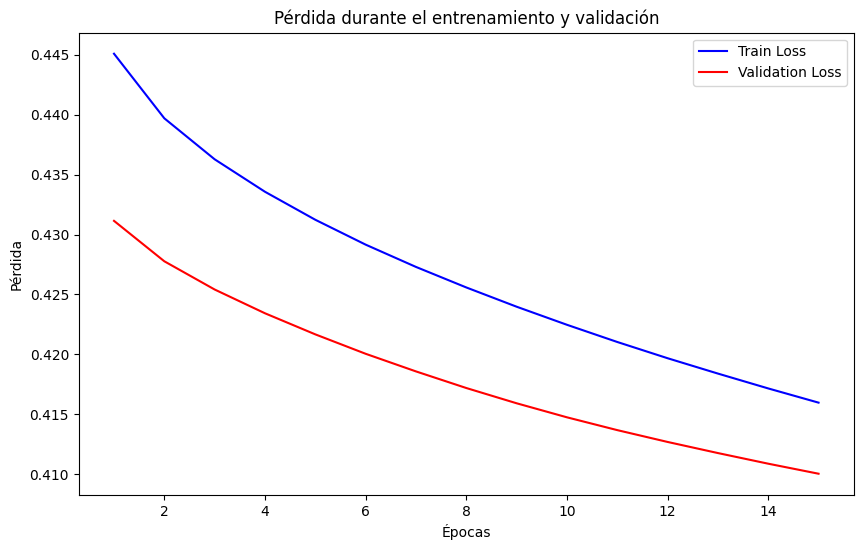

In [755]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), train_loss_hist, label='Train Loss', color='blue')
plt.plot(range(1, 16), val_loss_hist, label='Validation Loss', color='red')
plt.title('Pérdida durante el entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>

¿Que conclusiones puedes obtener de las gráficas tanto de la pérdida (`loss`) como de la exactitud (`accuracy`) en el entrenamiento y la validación a lo largo de las épocas?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
  
Es hora evaluar el rendimiento del modelo en el conjunto de test. Para ello:
   
1. Realiza la predicción sobre el conjunto de test.
2. Calcula las métricas de los apartados anteriores: accuracy, f1 score y curva roc.
 
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [760]:
model.eval()

with torch.no_grad(): 
    y_pred_test = model(X_test_tensor) 
    y_pred_test = y_pred_test.squeeze()

y_pred_test_bin = (y_pred_test >= 0.5).float()

accuracy = binary_accuracy(y_pred_test_bin, y_test_tensor)
f1 = binary_f1_score(y_pred_test_bin, y_test_tensor)
roc_auc = binary_auroc(y_pred_test, y_test_tensor)


In [ ]:
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.7805
F1 Score: 0.7725
AUC-ROC: 0.8710


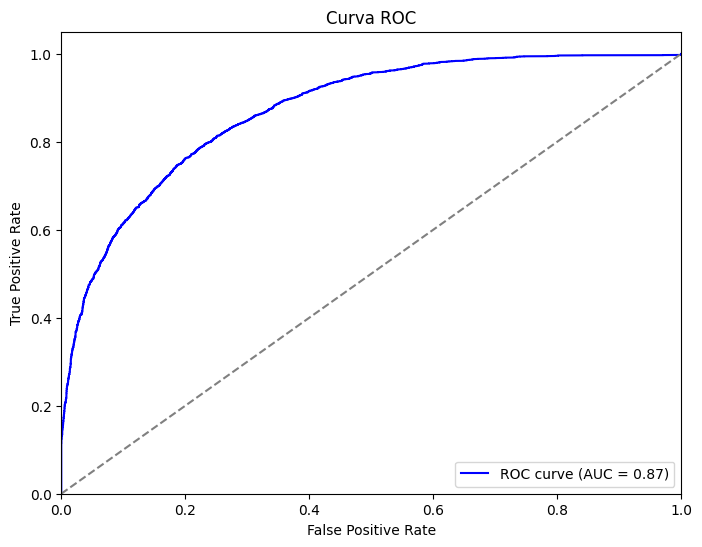

In [ ]:
#curva ROC

# Calcular las tasas de verdaderos positivos (TPR) y falsos positivos (FPR)
fpr, tpr, _ = roc_curve(y_test_tensor.numpy(), y_pred_test.numpy())
roc_auc_score = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>

Para analizar el modelo entrenado, nos vamos a apoyar en los [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), los cuales nos introducen a la explicación de modelos de aprendizaje automático. El objetivo es explicar la predicción de un modelo calculando la contribución de cada característica a la predicción. La explicación técnica del concepto de SHAP es el cálculo de los valores de Shapley a partir de la teoría de juegos. En pocas palabras, los valores de Shapley son un método para mostrar el impacto relativo de cada característica (o variable) que estamos midiendo en el resultado final del modelo de aprendizaje automático comparando el efecto relativo de las entradas con la media.

Para calcular los _shap values_:

1. Selecciona una muestra de 10000 registros del conjunto de entrenamiento.
2. Inicializa el 'explainer' `shap.DeepExplainer` con el modelo entrenado y la muestra anterior.
3. Selecciona una muestra de 400 registros del conjunto de entrenamiento.
4. Calcula los _shap_ values utilizando la muestra anterior
5. Define y muestra un DataFrame con tres columnas
   - Media aritmética del valor absoluto de los valores
   - Desviación típica del valor absoluto de los valores
   - Nombre del atributo descriptivo
6. Muestra la representación gráfica de los valores utilizando la librería shap.
 
</div>

<div class="alert alert-block alert-danger">
<strong>Solución:</strong>
</div>

In [765]:
sample_size = 10000
X_train_sample = X_train_tensor[:sample_size]

In [766]:
explainer = shap.DeepExplainer(model, X_train_sample)

In [769]:
sample_test_size = 400
X_test_sample = X_train_tensor[:sample_test_size]

In [770]:
shap_values = explainer.shap_values(X_test_sample)

In [772]:
# Tomar los valores absolutos de los SHAP values de la clase positiva
shap_values_abs = np.abs(shap_values[0])  # Tomar los valores absolutos de la clase 1

# Crear un DataFrame con los valores absolutos de SHAP para cada característica
shap_df = pd.DataFrame(shap_values_abs, columns=[f"Feature {i+1}" for i in range(X_train_tensor.shape[1])])

# Calcular la media y desviación estándar de los valores SHAP absolutos por cada característica
shap_summary_df = pd.DataFrame({
    "Feature": [f"Feature {i+1}" for i in range(shap_values_abs.shape[1])],
    "Mean Absolute SHAP Value": shap_df.mean(axis=0).values,
    "Std Deviation of SHAP Value": shap_df.std(axis=0).values
})

# Ordenar por la media de los valores absolutos de SHAP de mayor a menor
shap_summary_df = shap_summary_df.sort_values(by="Mean Absolute SHAP Value", ascending=False)

# Mostrar el DataFrame
print(shap_summary_df)



ValueError: Shape of passed values is (38, 1), indices imply (38, 38)

In [ ]:
shap.summary_plot(shap_values[0], X_test_sample)


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    
Relaciona la interpretación de los _shap values_ con el análisis exploratorio de los datos realizado en el ejercicio 2.2.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    
Imagina que calculamos los _shap values_ para cada split en el ejercicio en el que entrenamos el modelo utilizando validación cruzada. 
- ¿Los análisis de los diferentes modelos deberían ser similares? ¿Por qué o por qué no?
- ¿Qué indicaría si el análisis de cada modelo varía mucho de uno a otro?
- ¿Qué usos adicionales les podemos dar a los _shap values_?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong>
</div>